# 3D Scanning Parameters in T Cell Ternary Body Formation
## Analyzing antibody dissociation from covalently bonded SNAP
This is a script for analyzing the importance of the antibody dissociation rate from a CAR T Cell or a SNAP T Cell. Where as the setup script assumed no dissociation between T Cells and the antibody, we will be scanning the parameter space for optimum dissociation rates. 

### Importing the important packages to simulate the model.

In [3]:
%matplotlib inline
import math
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

### Copy Pasta
Much of the following code is copied from the script, "B_TernaryBody_ParameterScan_DissociationConstant". It must be repeated to be referenced in this script. 

In [4]:
#Parameters for the parameter scan
Dissociation_Rate_upper_bound = 10**-3 #(units = M) Dissociation constant of antibody in Molar 
Dissociation_Rate_lower_bound = 10**-9 #(units = M) Dissociation constant of antibody in Molar

#Regular Parameters from before
number_of_receptors_per_Tcell = 100000  #(units = molecules per cell) Receptors per T cell
number_of_receptors_per_tumor = 100000  #(units = molecules per cell) Receptors per Tumor cell
alpha = 10                              #Cooperativity rate 
                                        #####   Cooperativity   #####
                                        # (0 to 1)  is negative cooperativity
                                        # (1)       is no cooperativitiy
                                        # (1 to inifinity) is positive cooperativity

In [5]:
#Calculating the number of steps to effectively show the parameter scan
log_lower_bound = np.log10(Dissociation_Rate_lower_bound) 
log_upper_bound = np.log10(Dissociation_Rate_upper_bound) 
step_size = int(abs(log_lower_bound-log_upper_bound) + 1)
# step_size = 7                           #The number of steps in the parameter scan (logarithmic)

#Variables given for the experimental setup
Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
reaction_volume = 150                                    #150 uL reaction volume
number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
number_of_tumor_cells = 400000                           #400,000 Tumor Cells in reaction      

#Calculating the initial molecular concentrations
Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)
Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume)
Concentration_of_Antibody = 1 #Necessary to initialize the simulation, actual value is a range


#Saving the variables for simulation
Initial = [Concentration_of_T_Cells,Concentration_of_Antibody,Concentration_of_Tumor_Cells,0,0,0]
parameter_range = np.logspace(log_lower_bound,log_upper_bound,num=step_size, endpoint=True, base=10.0)
time = np.linspace(0,100000000,10000)

In [6]:
def rxn(C,t):
    #Loading the global variable reaction rates
    kf1 = k[0]                                             
    kr1 = k[1]                                             
    kf2 = k[2]                                             
    kr2 = k[3]                                             
    kf3 = k[4]                                             
    kr3 = k[5]                                             
    kf4 = k[6]                                             
    kr4 = k[7]        
    
    #Loading the initial concentrations
    C_snap = C[0]                   #initial concentration of free T Cell receptor
    C_anti = C[1]                   #initial concentration of free antibody
    C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
    C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
    C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
    C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
    
    #Separation of key equation terms for simplicity
    term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody                              
    term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
    term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
    term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
    term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
    term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
    term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
    term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body
    
    #ODEs that model the dynamic change in concentration of each chemical species
    d_C_snap_dt = - term1 + term2 - term7 + term8           #change in free T Cell receptor
    d_C_anti_dt = - term1 + term2 - term3 + term4           #change in free antibody
    d_C_tumo_dt = - term3 + term4 - term5 + term6           #change in free Tumor cell receptor
    d_C_snap_anti_dt = + term1 - term2 - term5 + term6      #change in bound T Cell - Antibody
    d_C_anti_tumo_dt = + term3 - term4 - term7 + term8      #change in bound Tumor Cell - Antibody
    d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8 #change in Ternary Body
    
    return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])

^^^^^^^^^^^^^ End of the Copy Pasta ^^^^^^^^^^^^^
### The script for creating a 3D plot of the Parameter Scan
This parallels the 2D plot format in that we must run the simulation to get all the data before plotting the figure. Unfortunately, matplotlib has some trouble plotting 3D figures in log scale. We collapse our data into the linear scale and change the axises to reflect this change.

In [7]:
# Simulate the model over a range
N = 30
antibody_range = np.logspace(-3,1,N)
Kd_range = np.logspace(-9,-3,N)
time = np.linspace(0,100000000,10000)
X, Y = np.meshgrid(antibody_range, Kd_range)
Z = np.zeros(X.shape)

row = 0
col = 0

for Kd in Kd_range:
    Antibody_dissociation = Kd
    #Calculating the Kinetic Parameters - since we only have equilibrium data, we are interested in ratios, not numbers
    k_binding_snap_to_antibody = 10**-5                      #
    k_release_snap_to_antibody = Antibody_dissociation  #Scanning the dissociation rate
    k_binding_antibody_to_tumor = 10**-5 
    k_release_antibody_to_tumor = k_binding_antibody_to_tumor * Antibody_dissociation * 10**-9
    k_cooperativity_binding_snap = k_binding_snap_to_antibody * alpha
    k_cooperativity_releasing_snap = k_release_snap_to_antibody * alpha
    k_cooperativity_binding_tumor = k_binding_antibody_to_tumor * alpha
    k_cooperativity_releasing_tumor = k_release_antibody_to_tumor * alpha

    k = [k_binding_snap_to_antibody,k_release_snap_to_antibody,k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor,k_cooperativity_binding_snap,k_cooperativity_releasing_snap,\
         k_cooperativity_binding_tumor,k_cooperativity_releasing_tumor]
    
    #the for loop to go over the range of the antibody concentrations
    for antibody in antibody_range:
        Initial[1] = antibody
        C = odeint(rxn,Initial,time)
        Z[row,col] = float((C[100,5]))        
        col += 1
    col = 0
    row += 1
    
#Collapse our Logspace to Linspace because matplotlib has difficulty with logspace plotting
lin_antibody = np.linspace(-3,1,N)
lin_Kd = np.linspace(-9,-3,N)
lin_X, lin_Y = np.meshgrid(lin_antibody, lin_Kd)

### Creating the figures for a 360 animation
We must create all the frames for the animation before merging them into a gif. This is to create a 360 degree view animation.

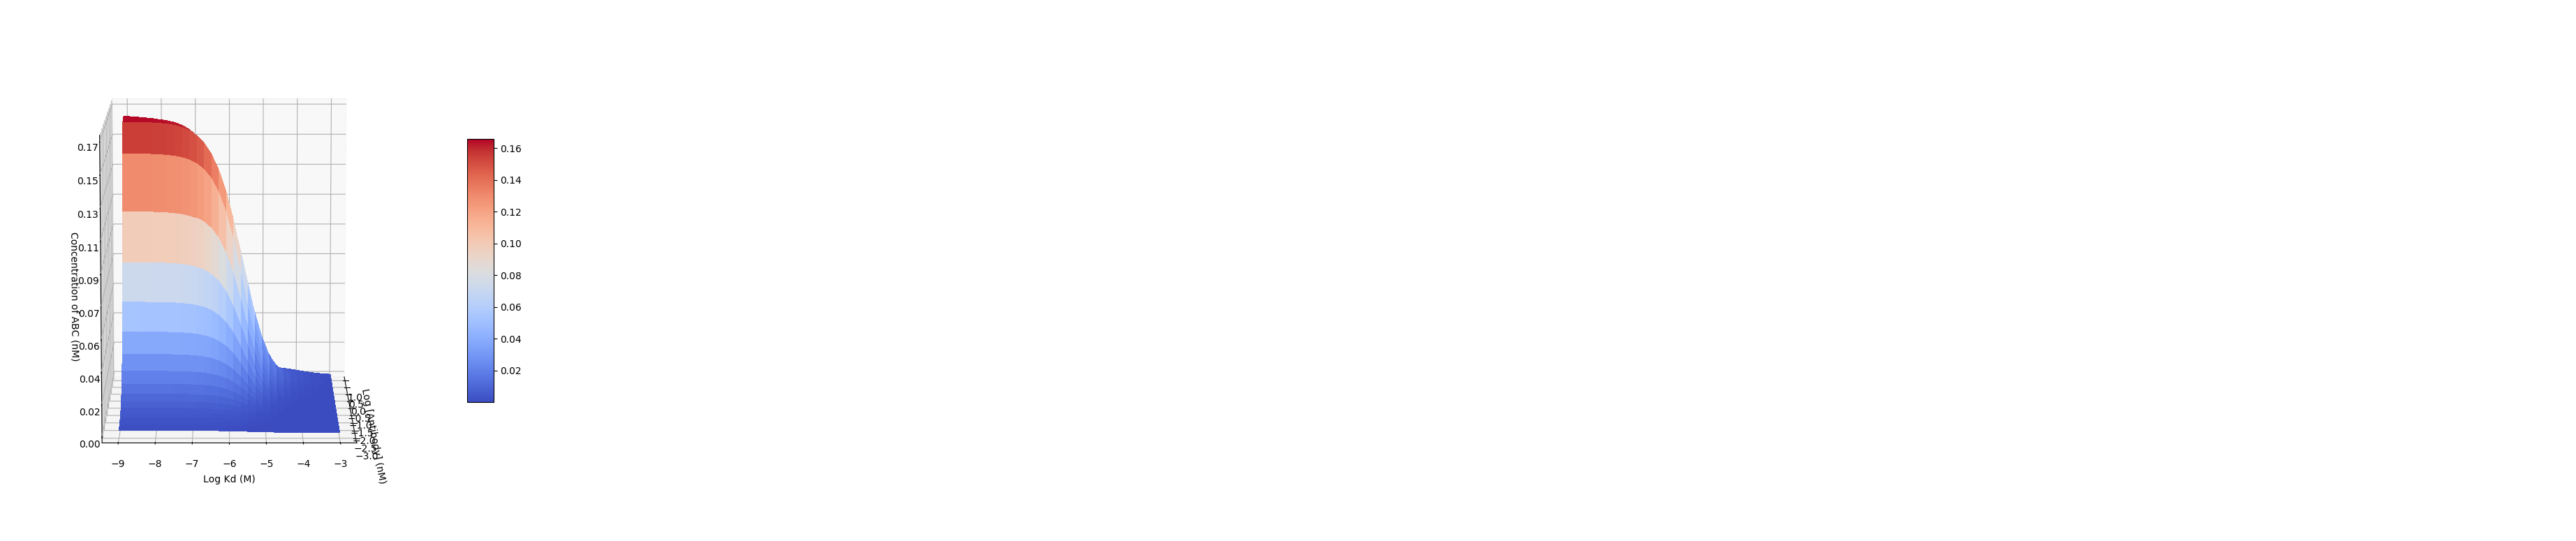

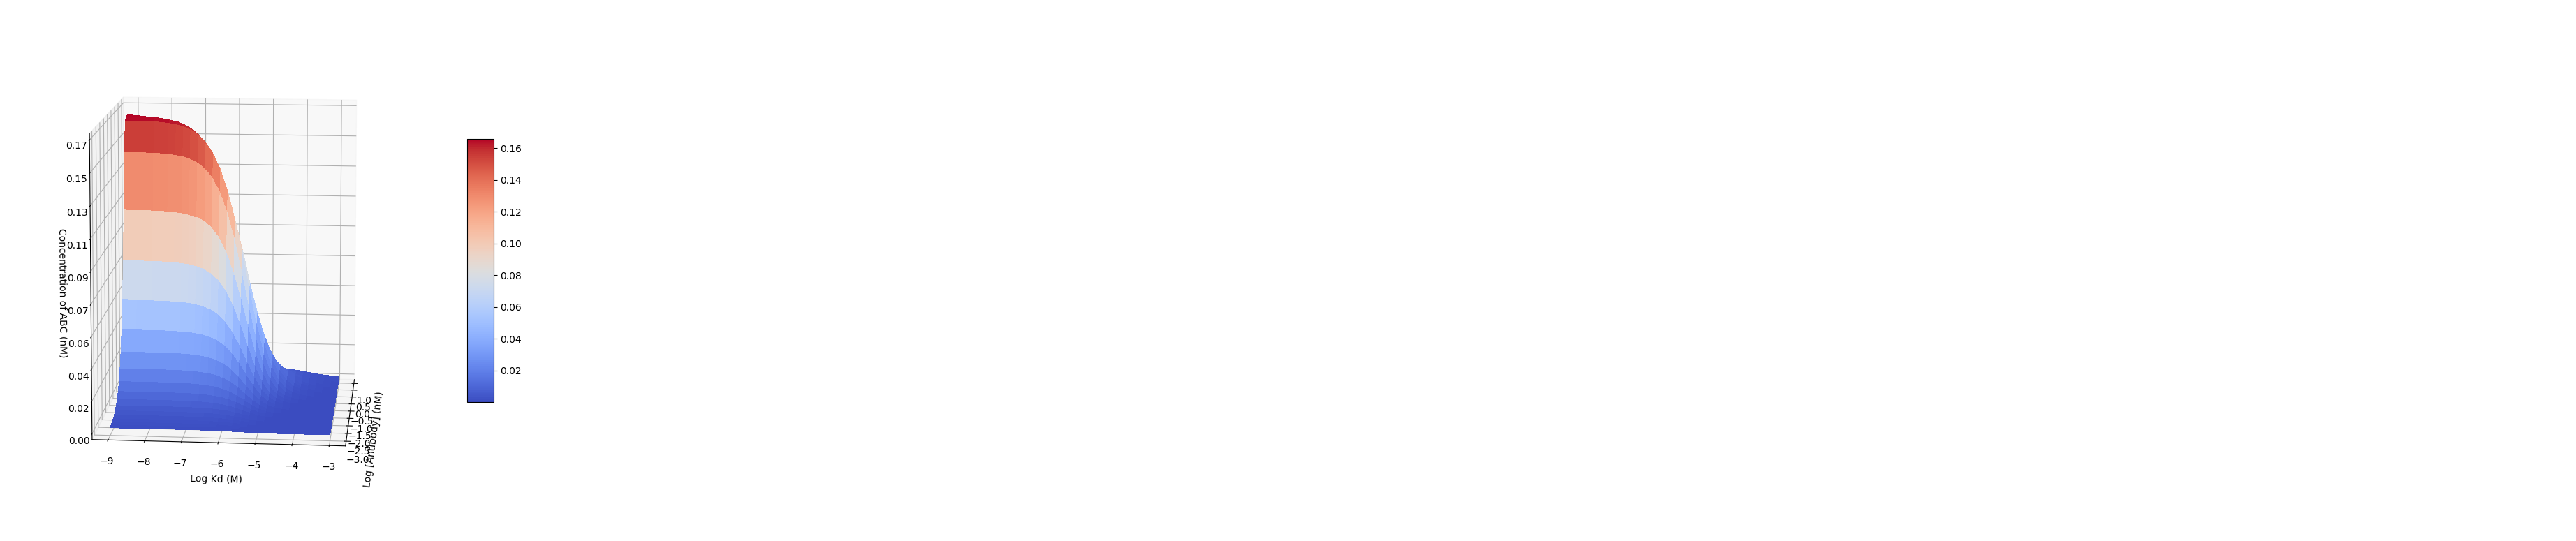

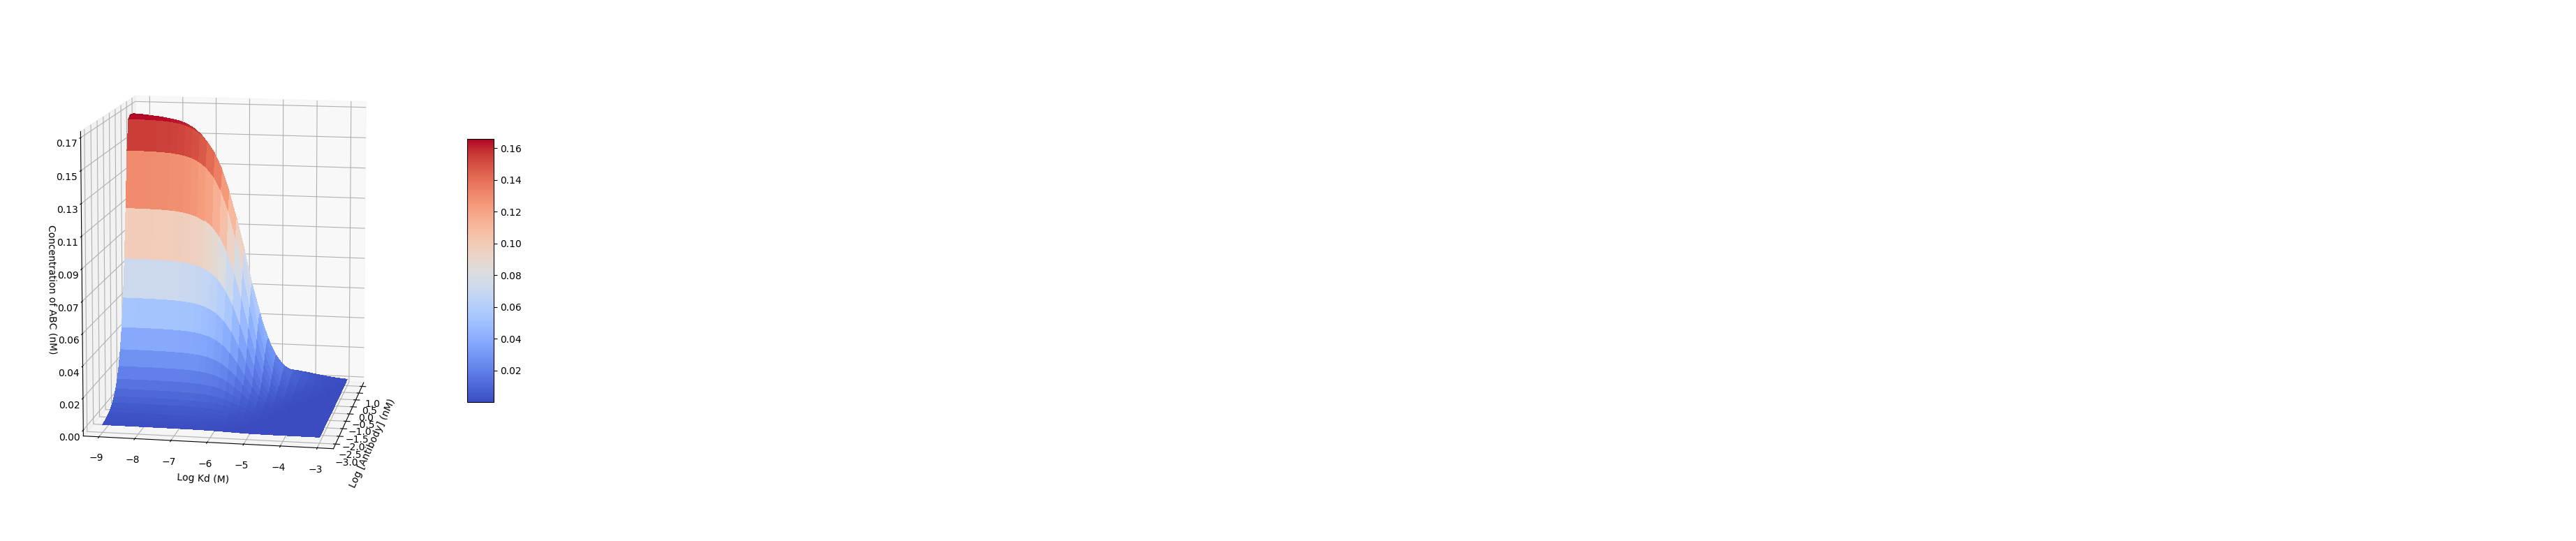

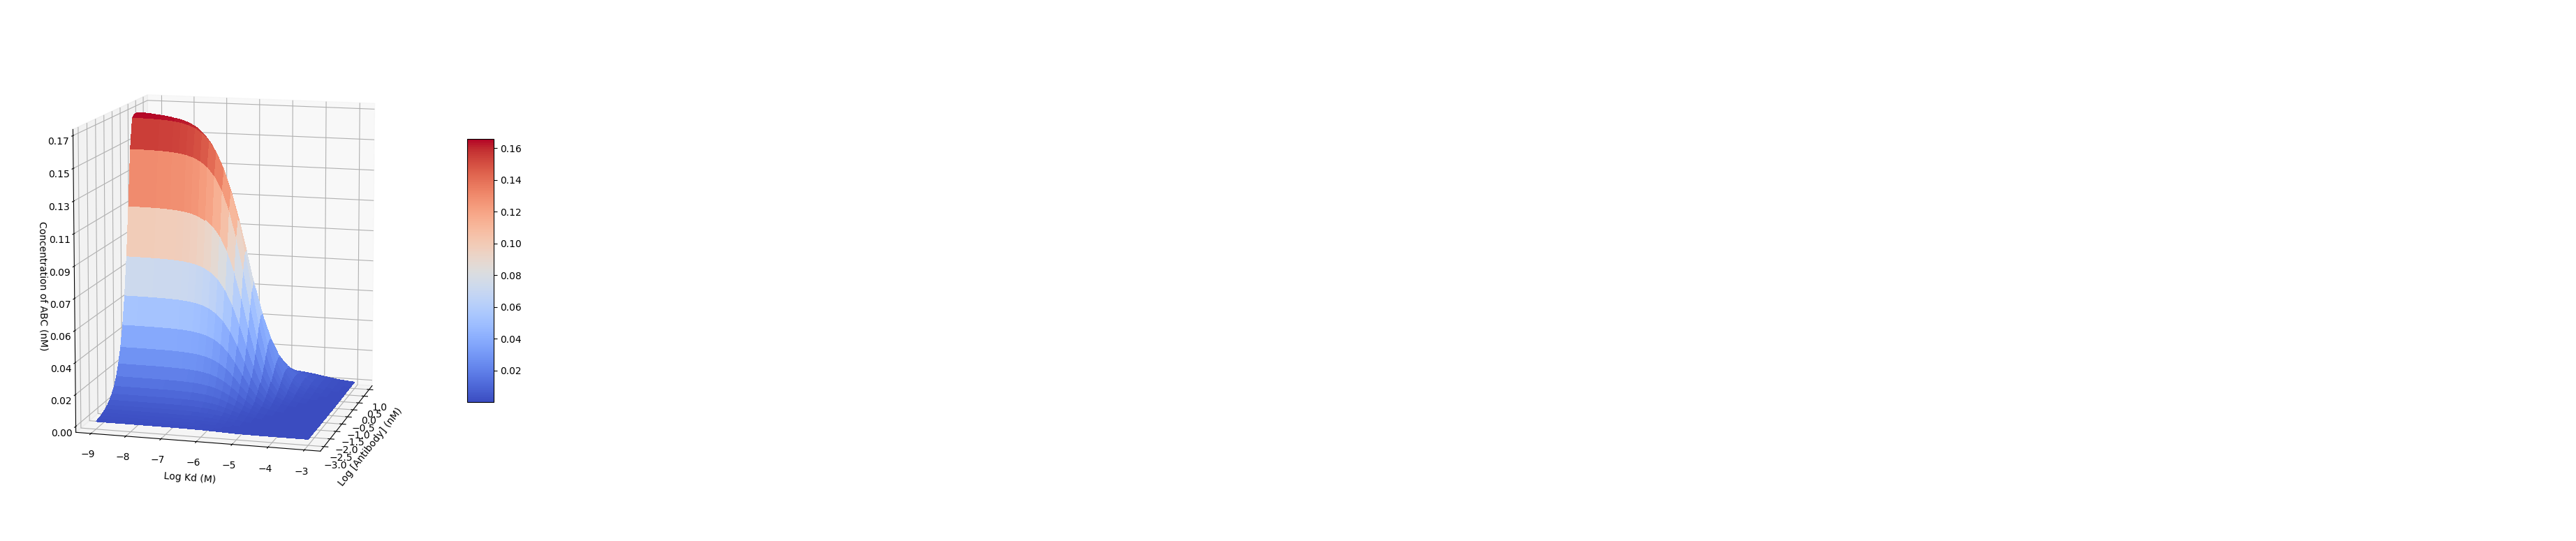

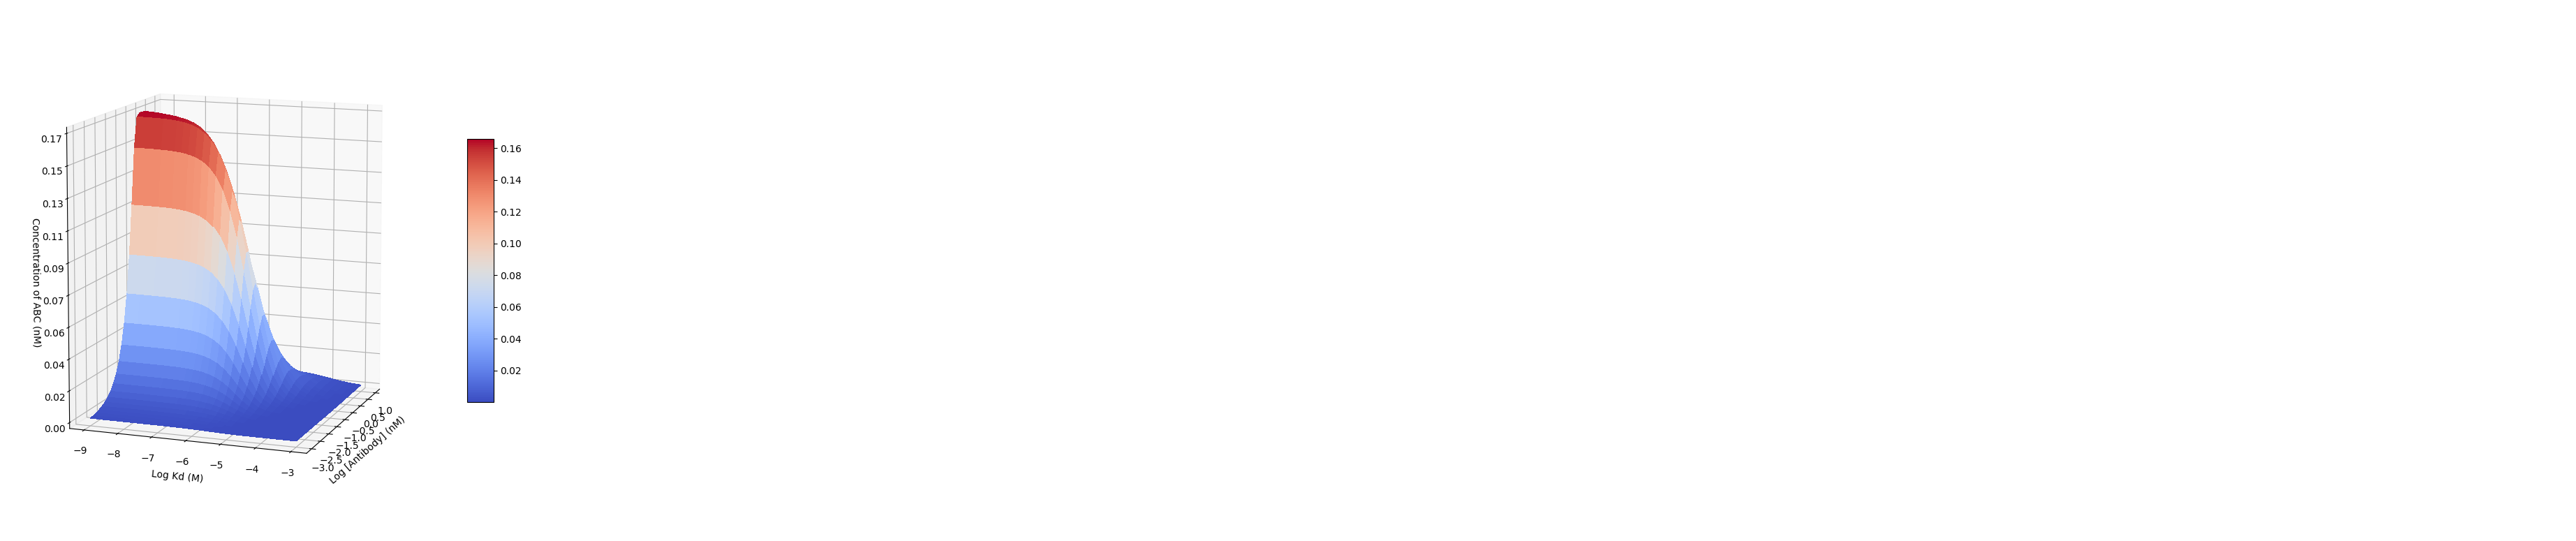

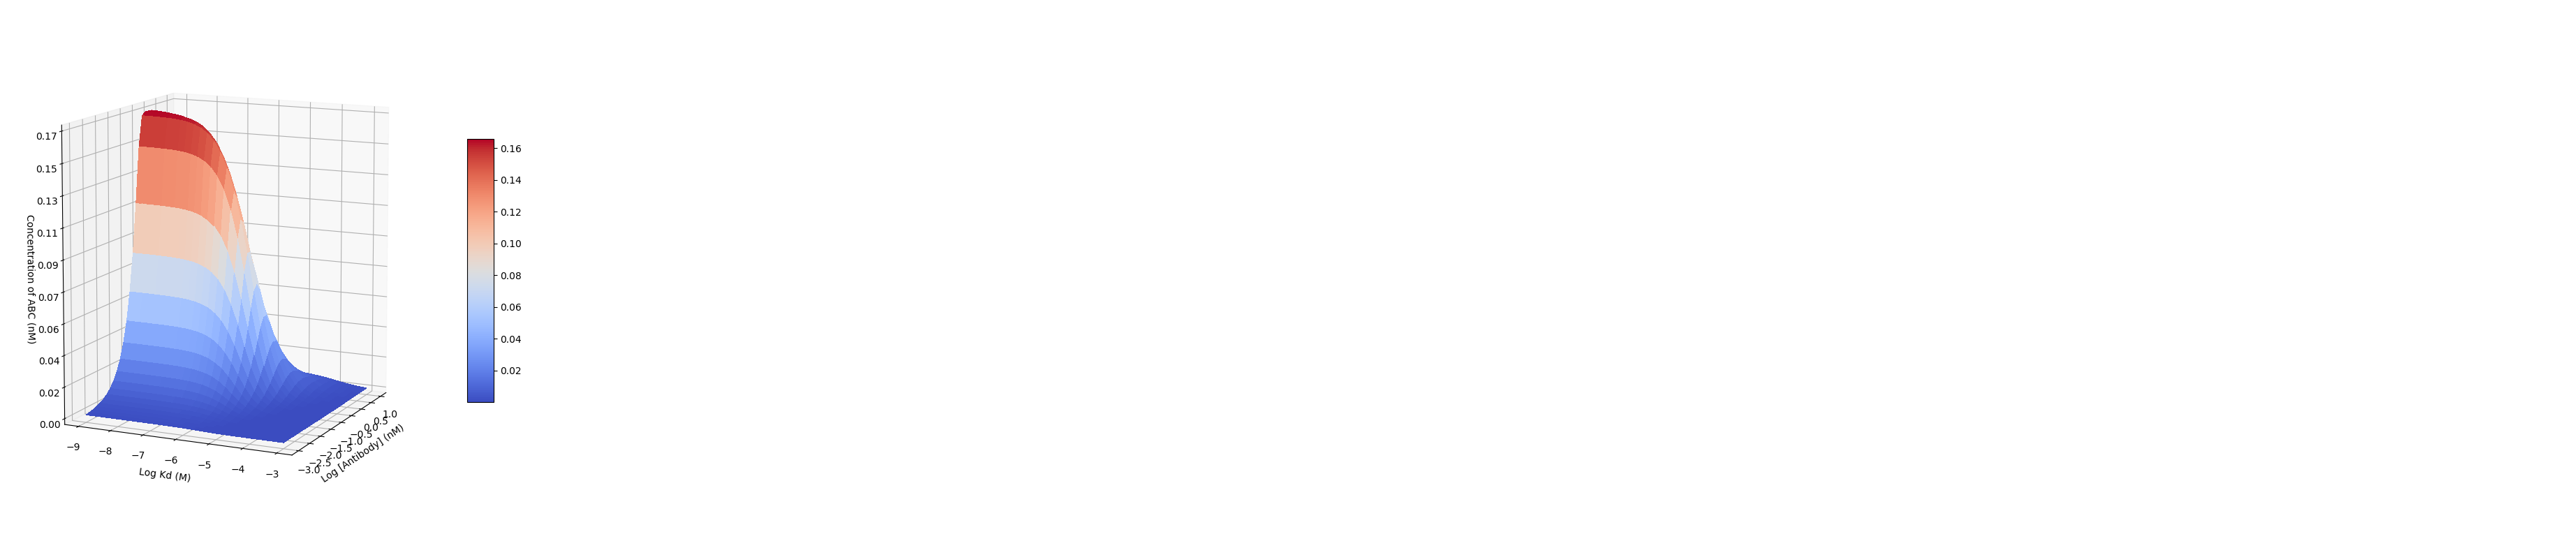

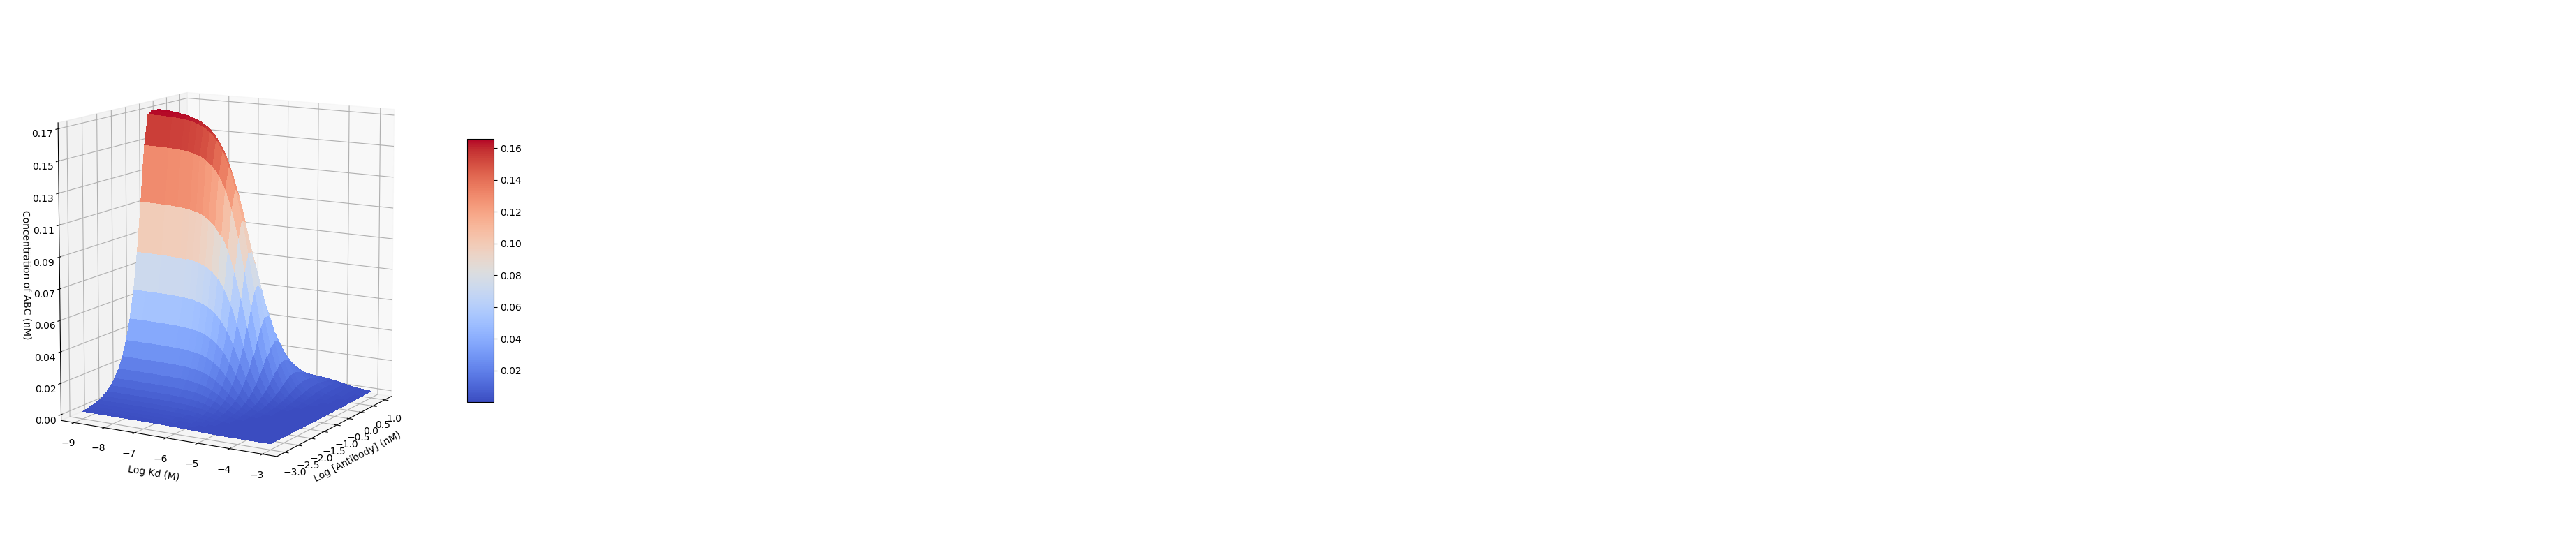

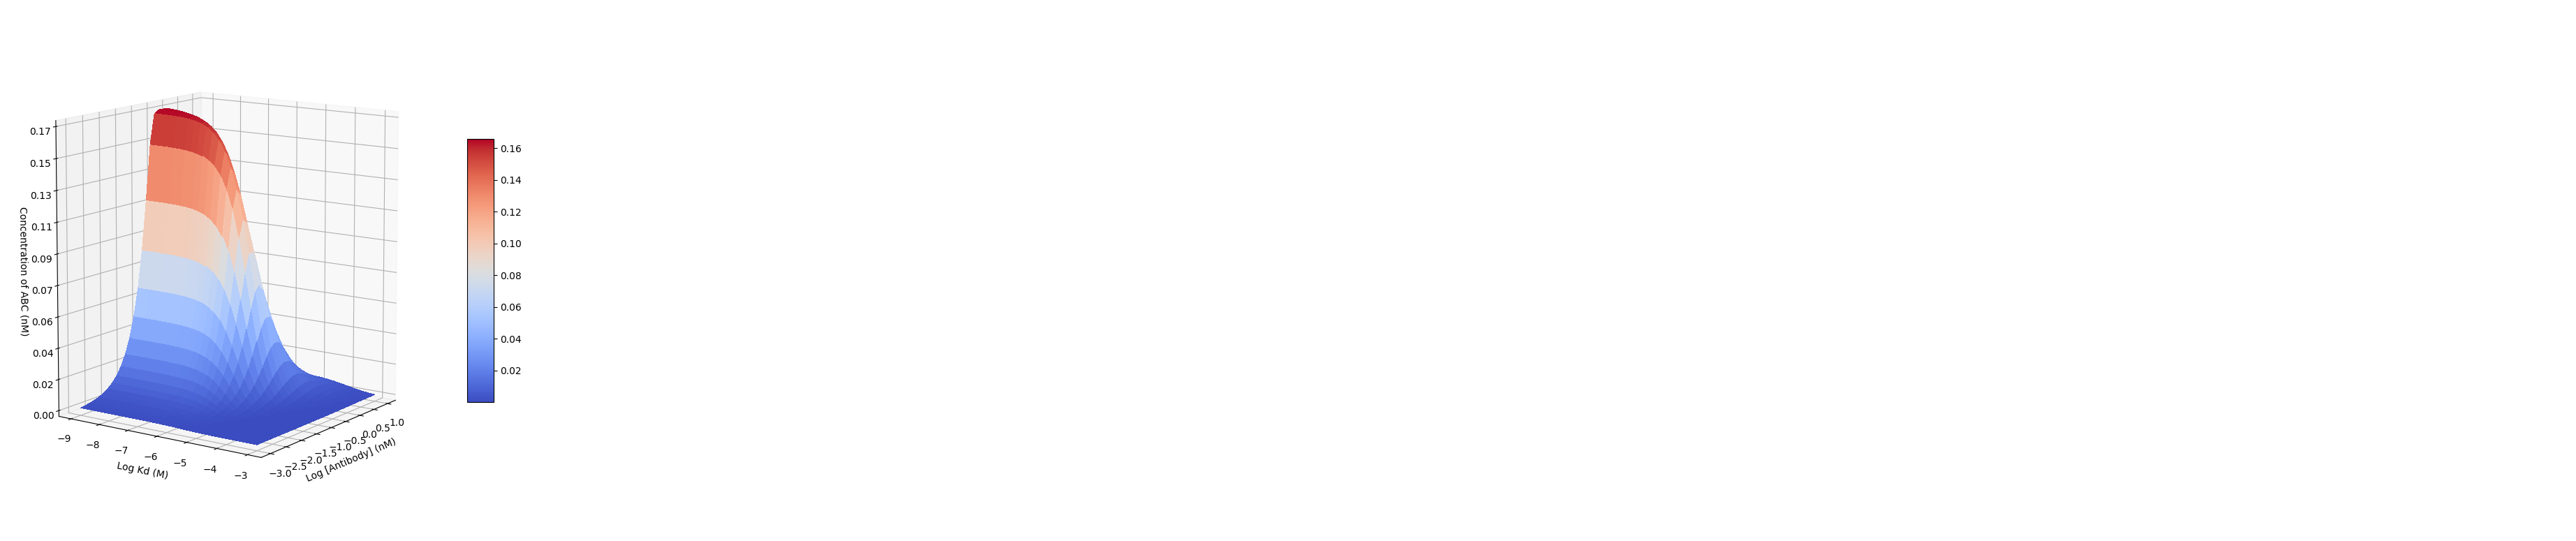

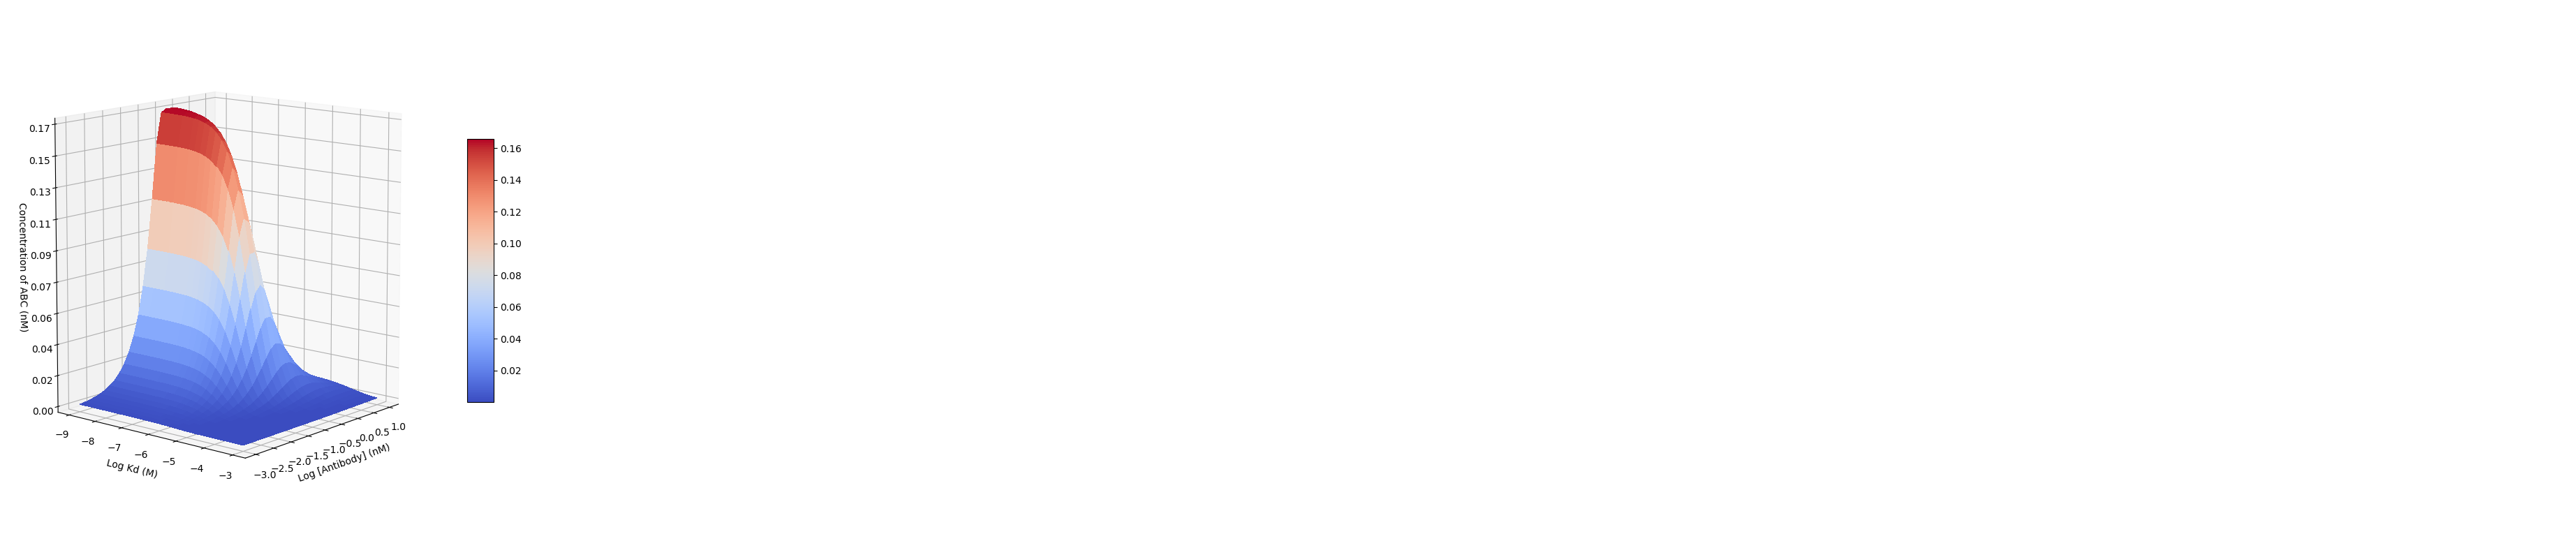

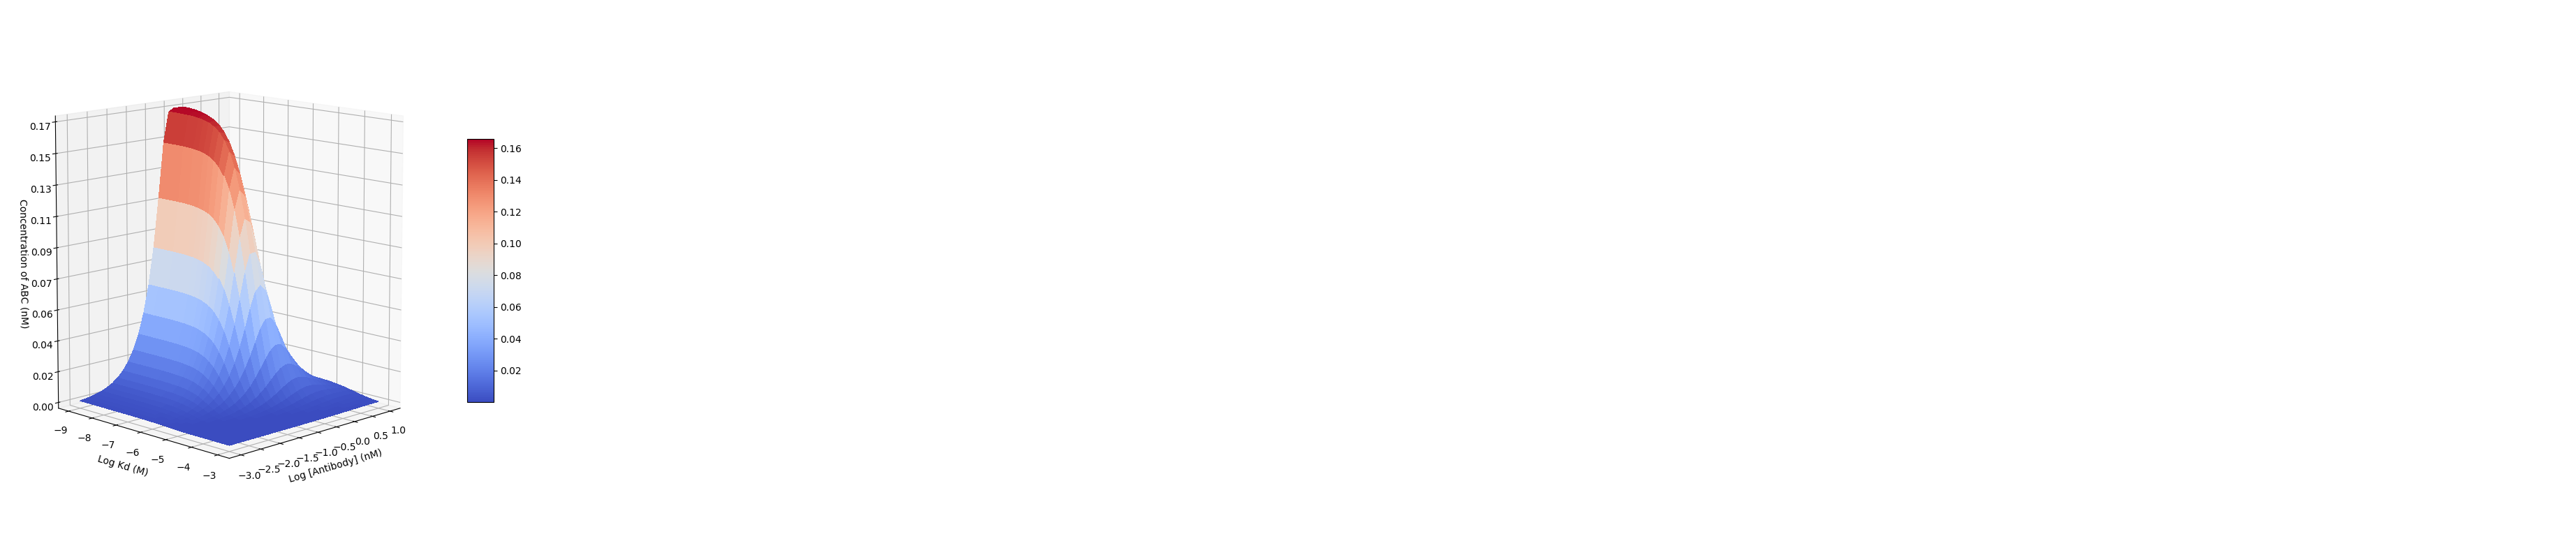

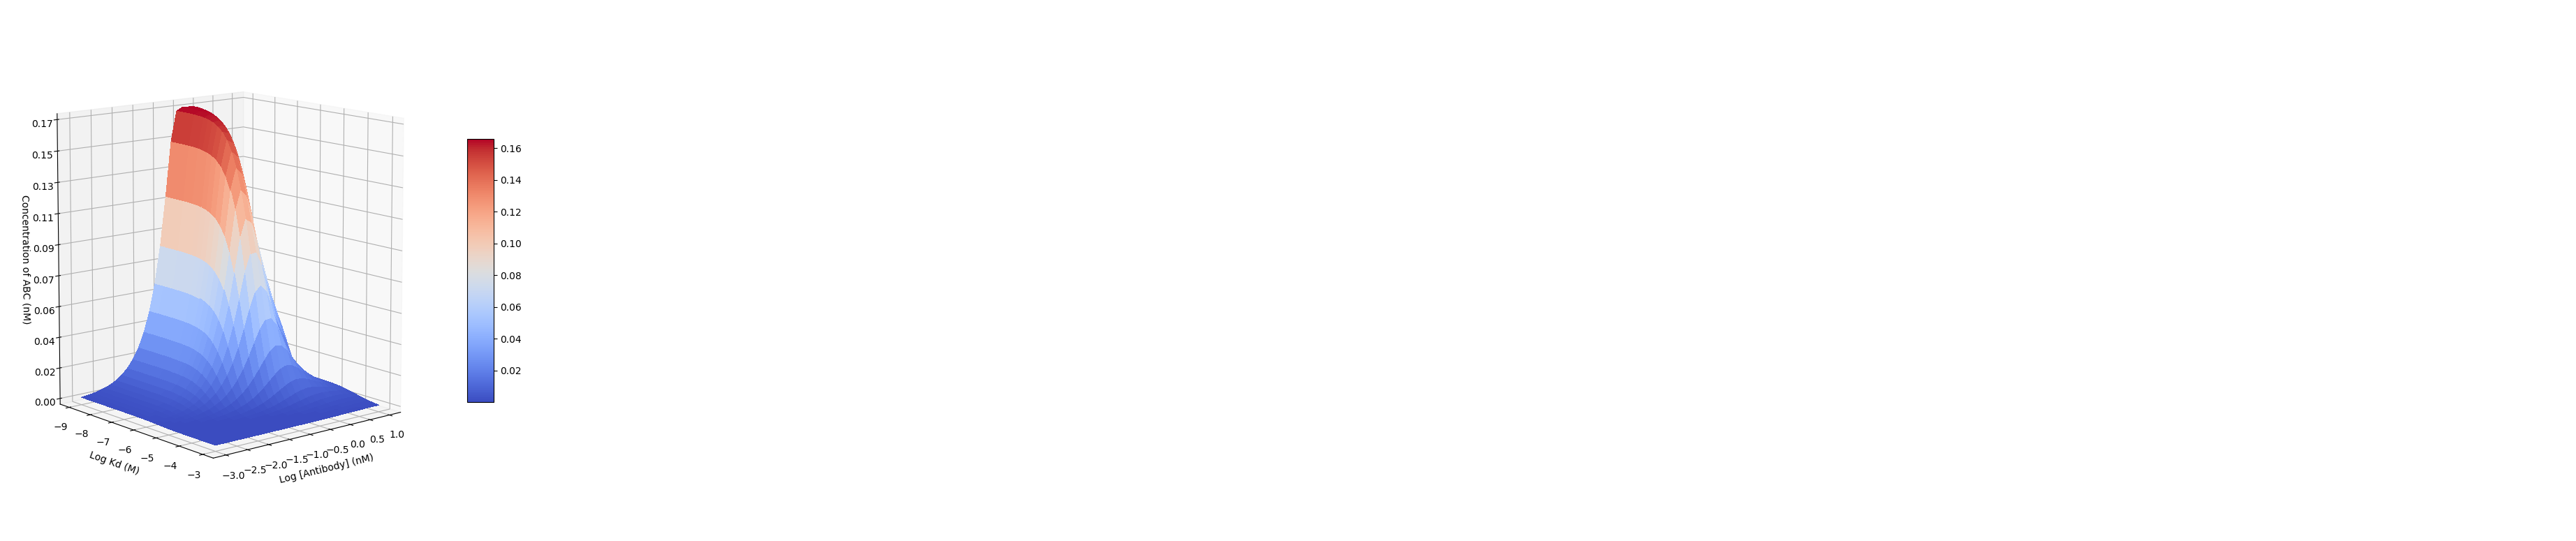

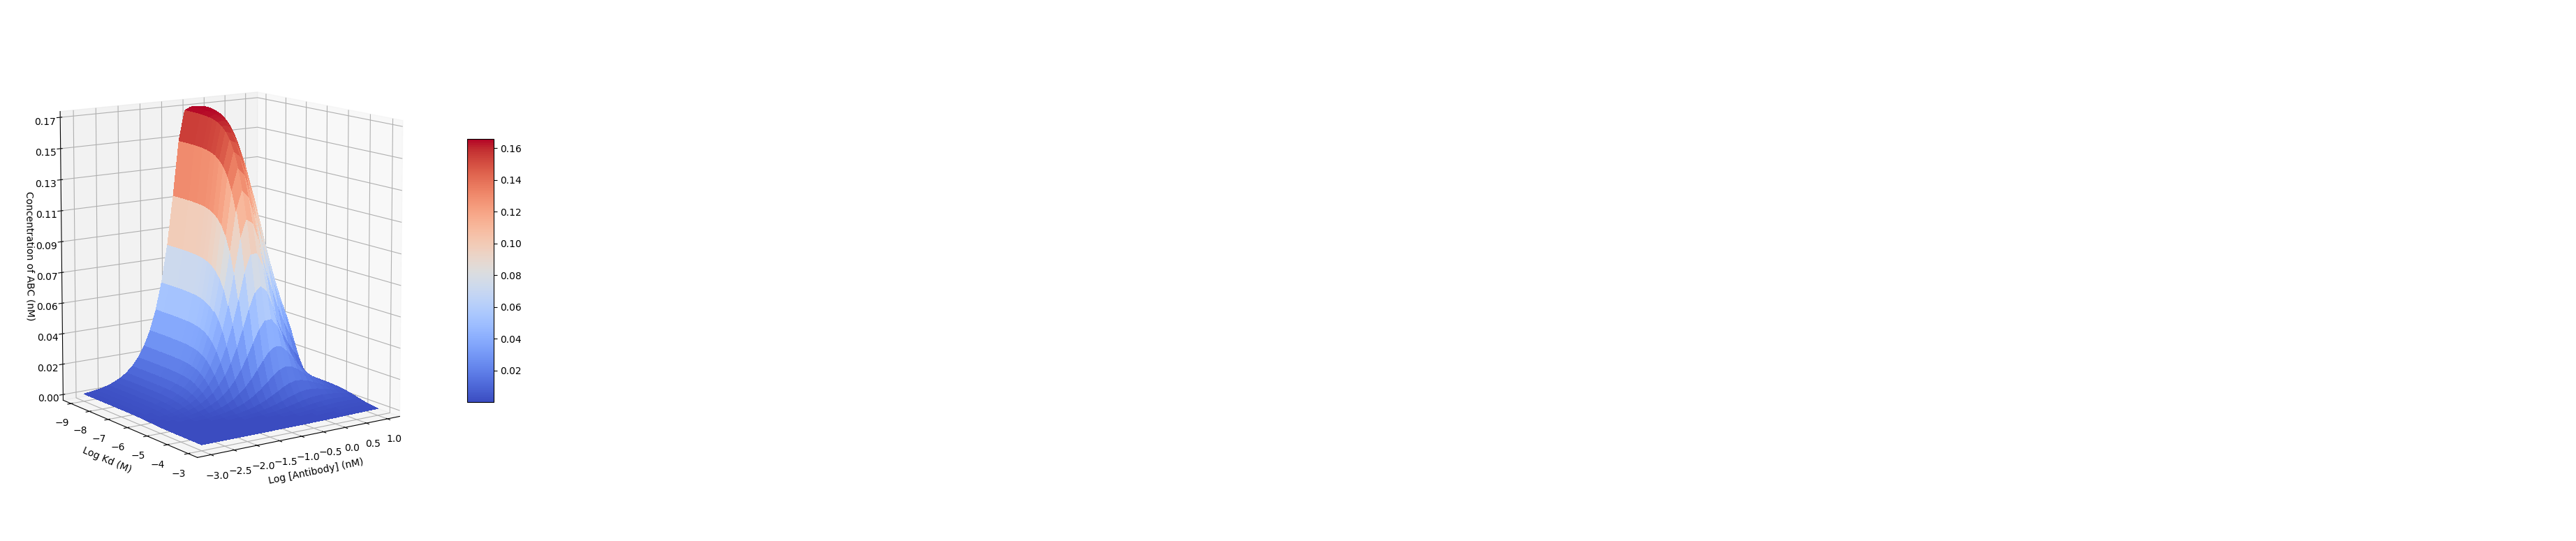

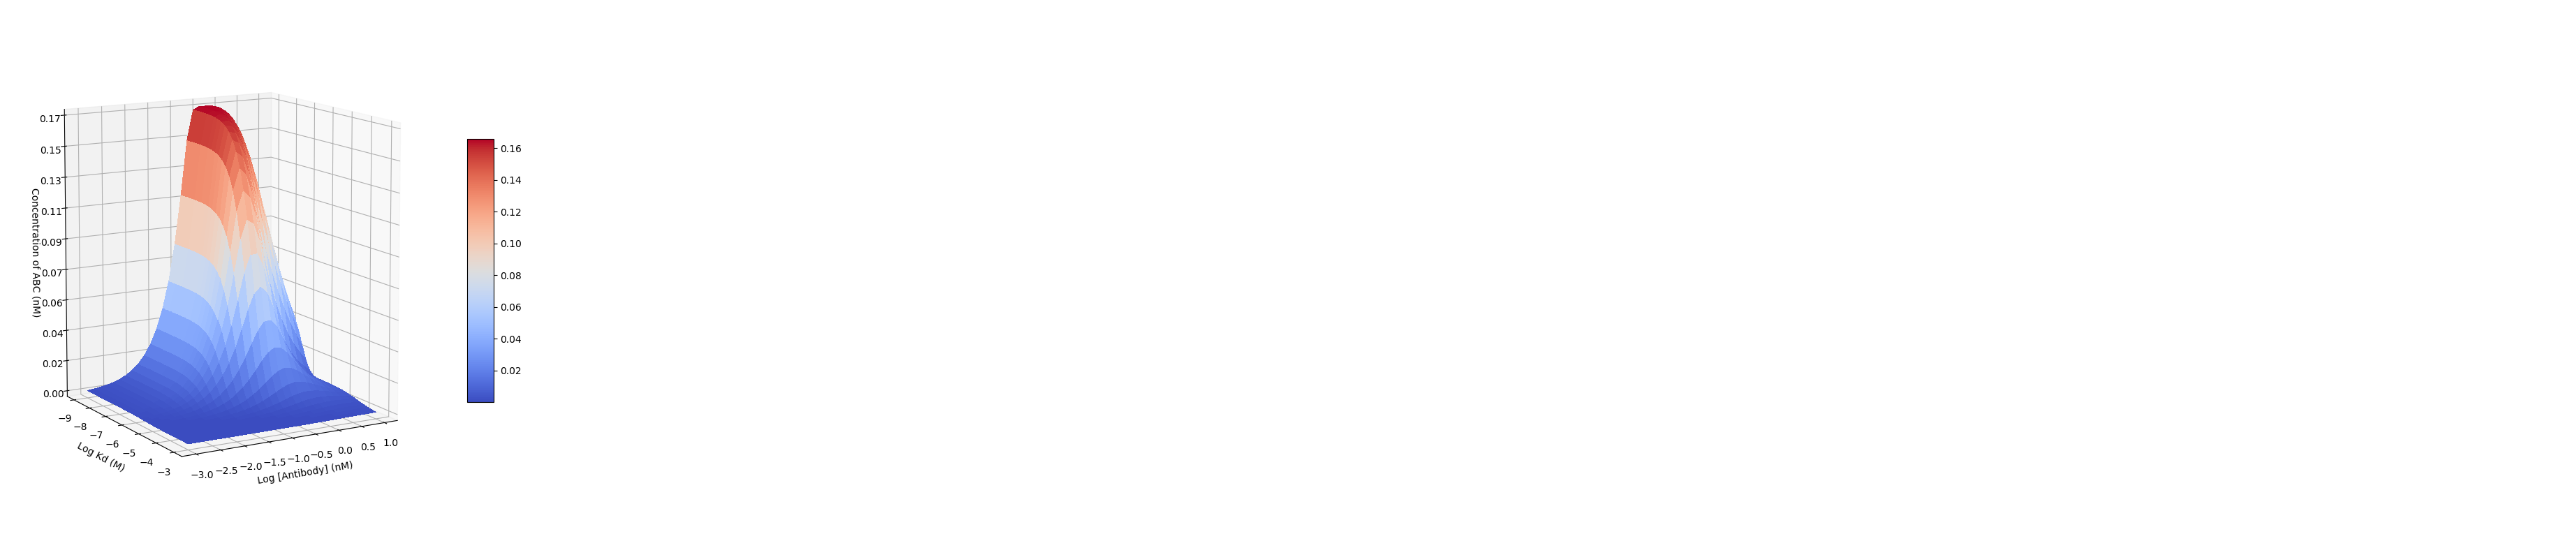

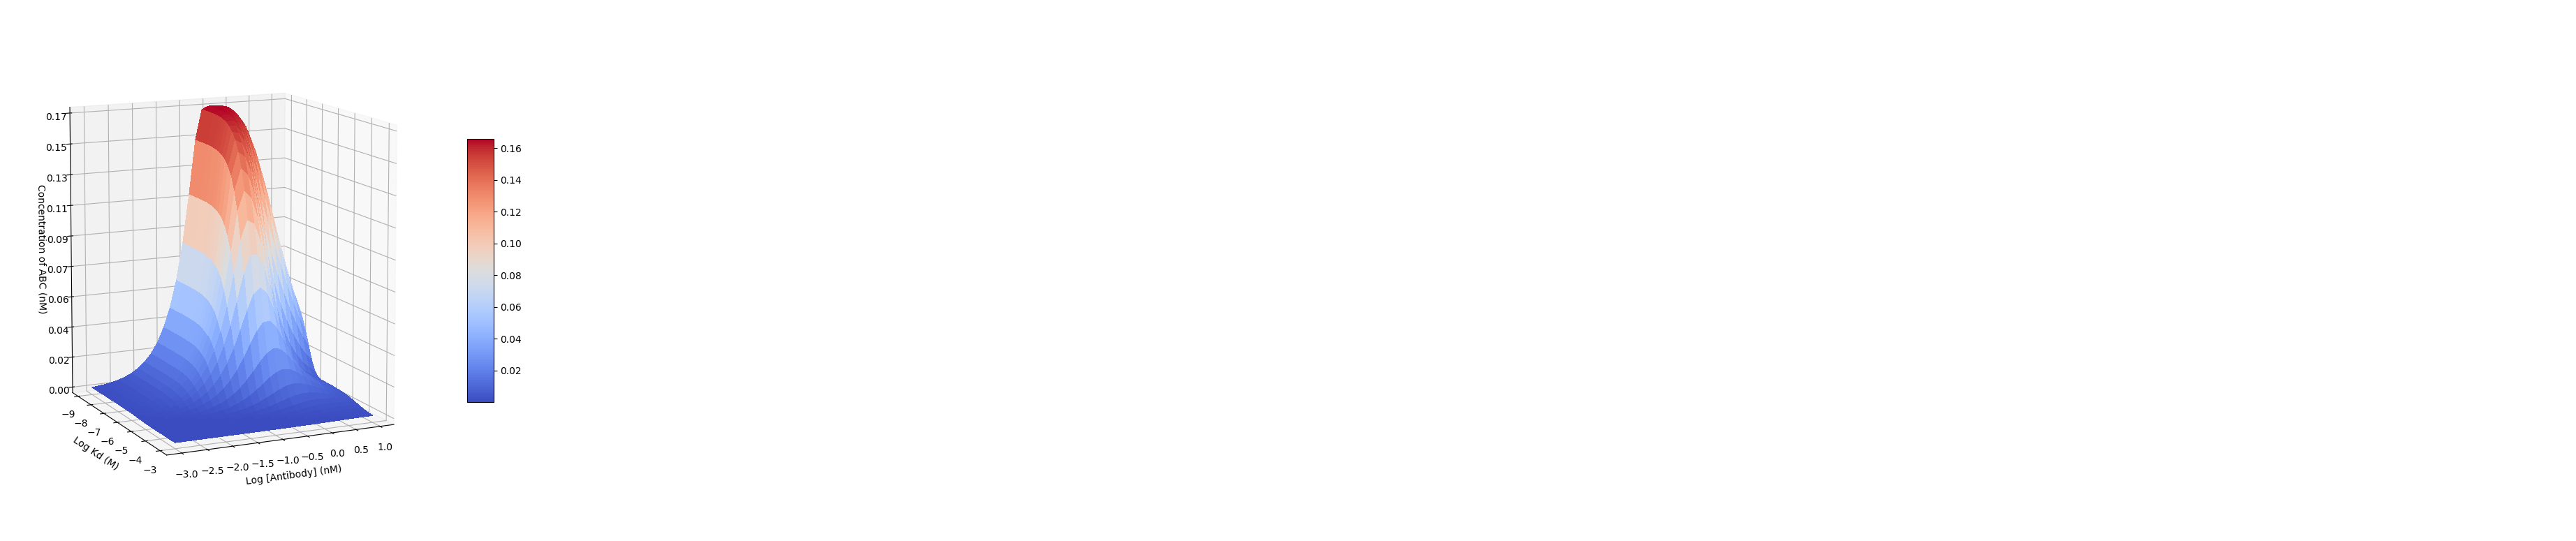

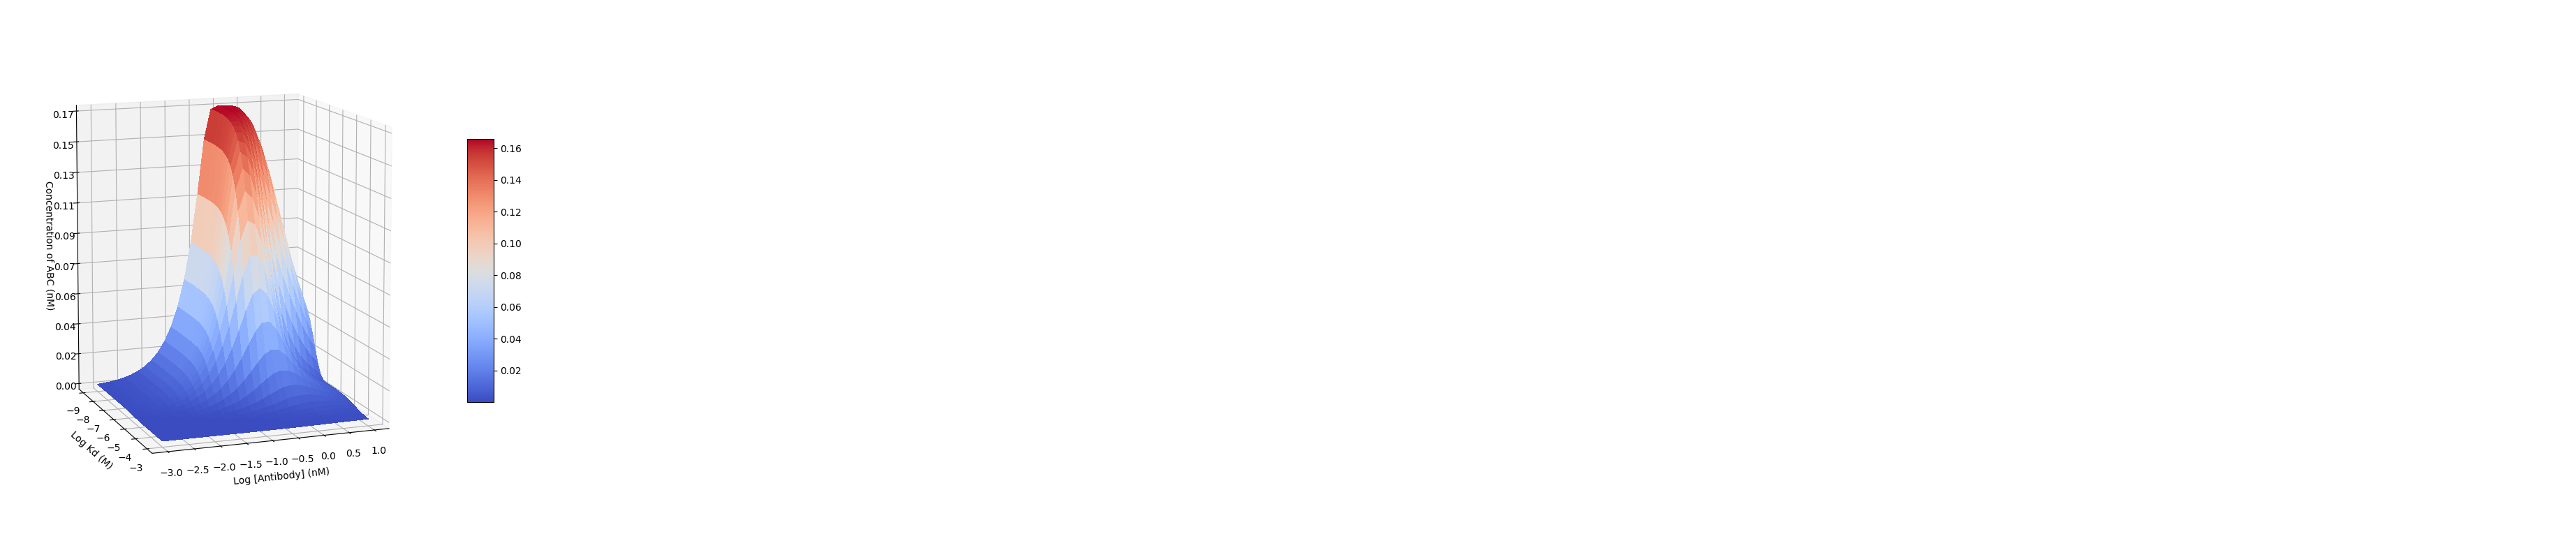

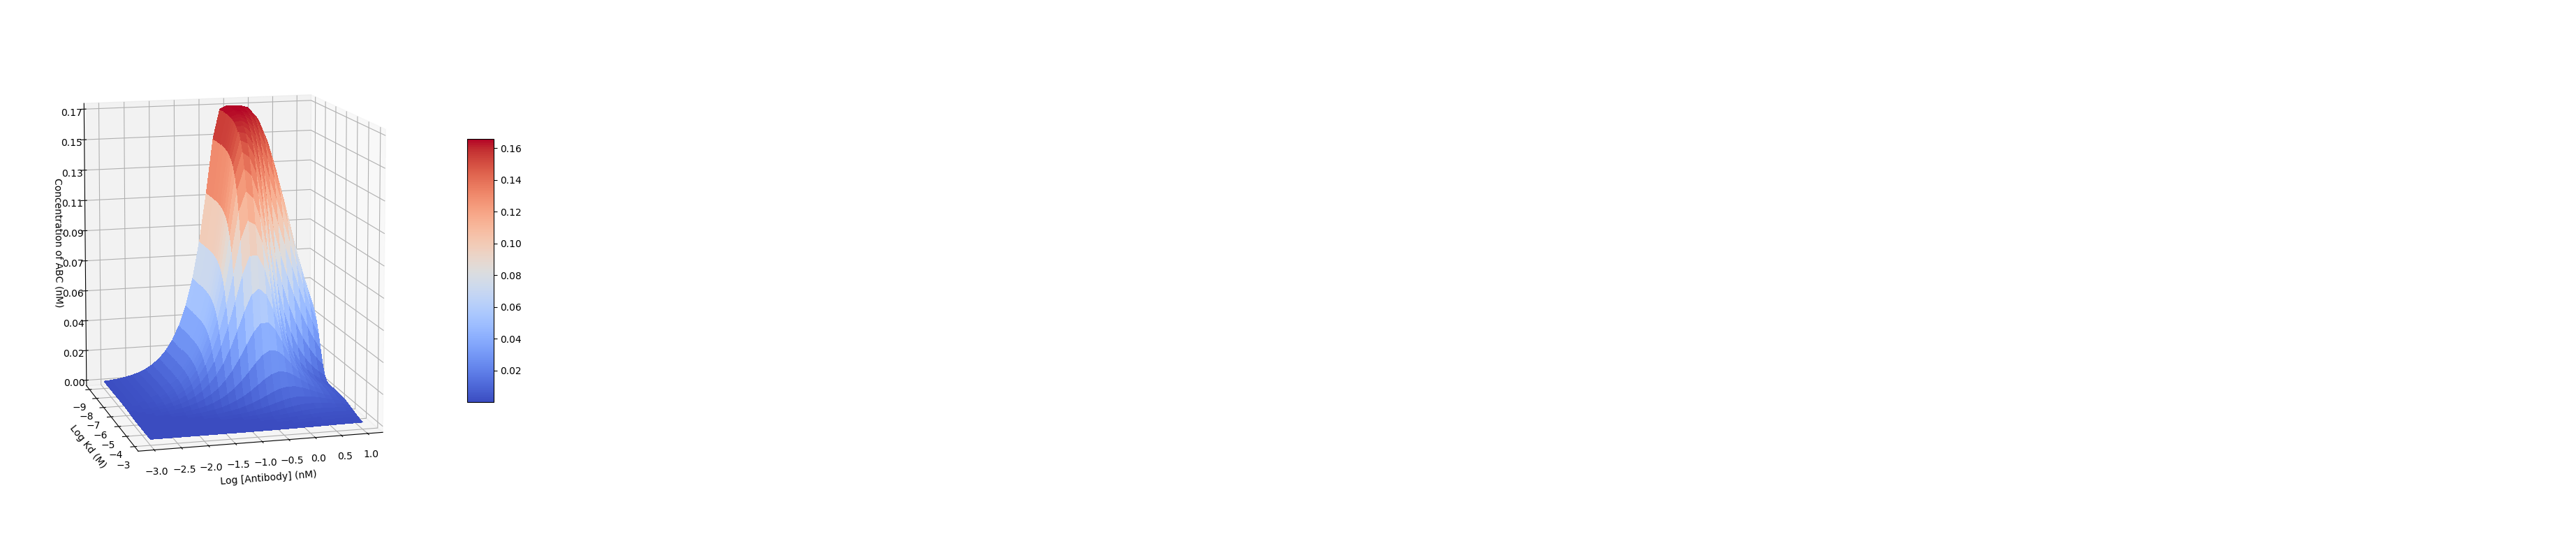

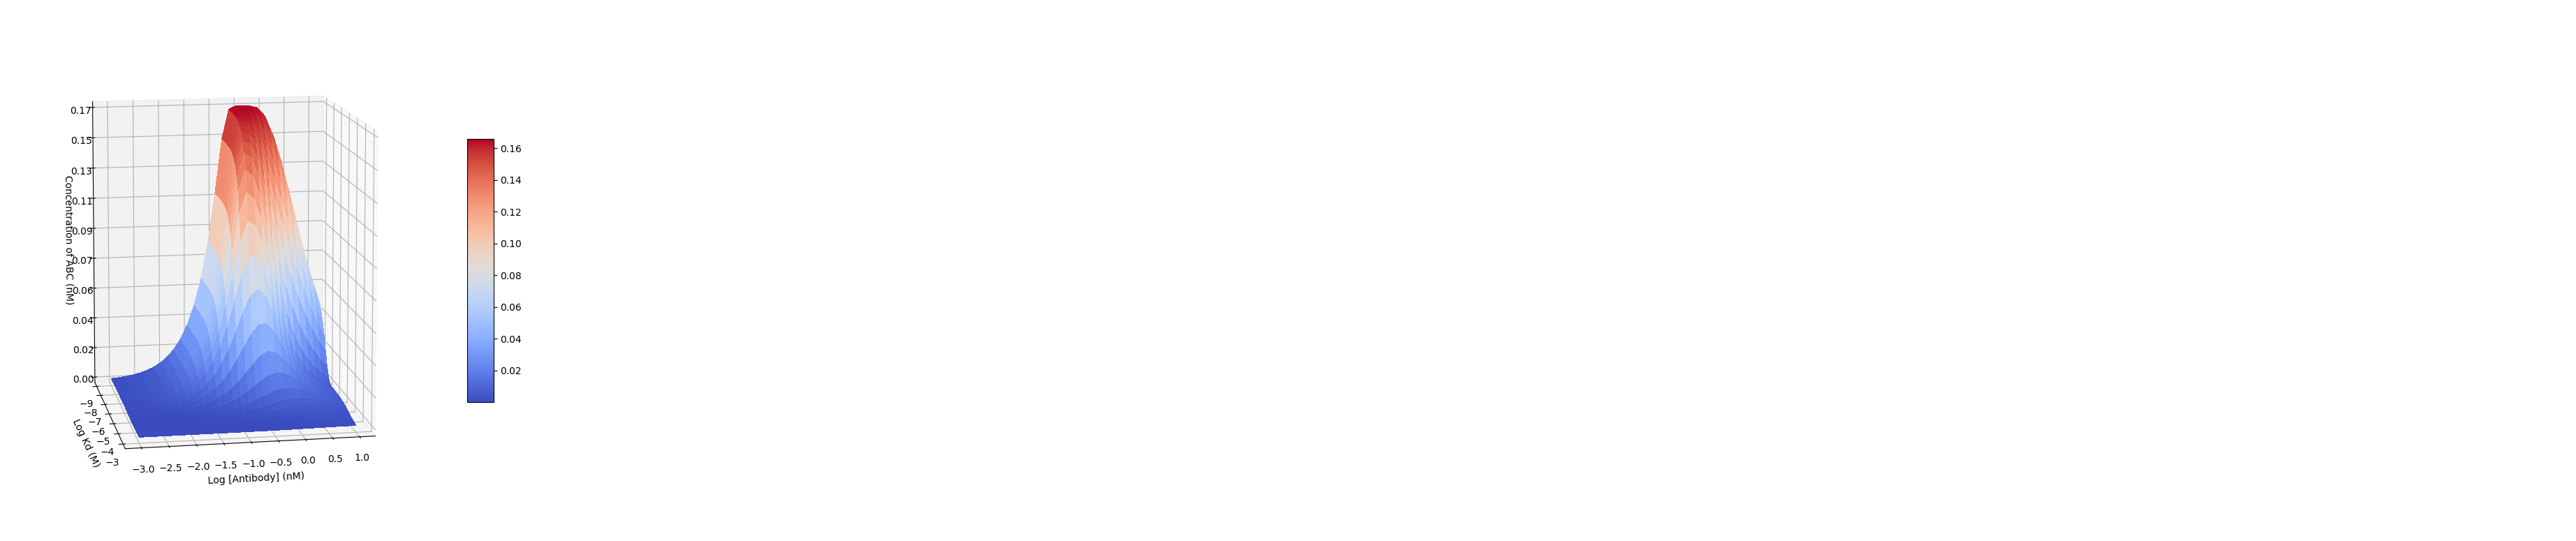

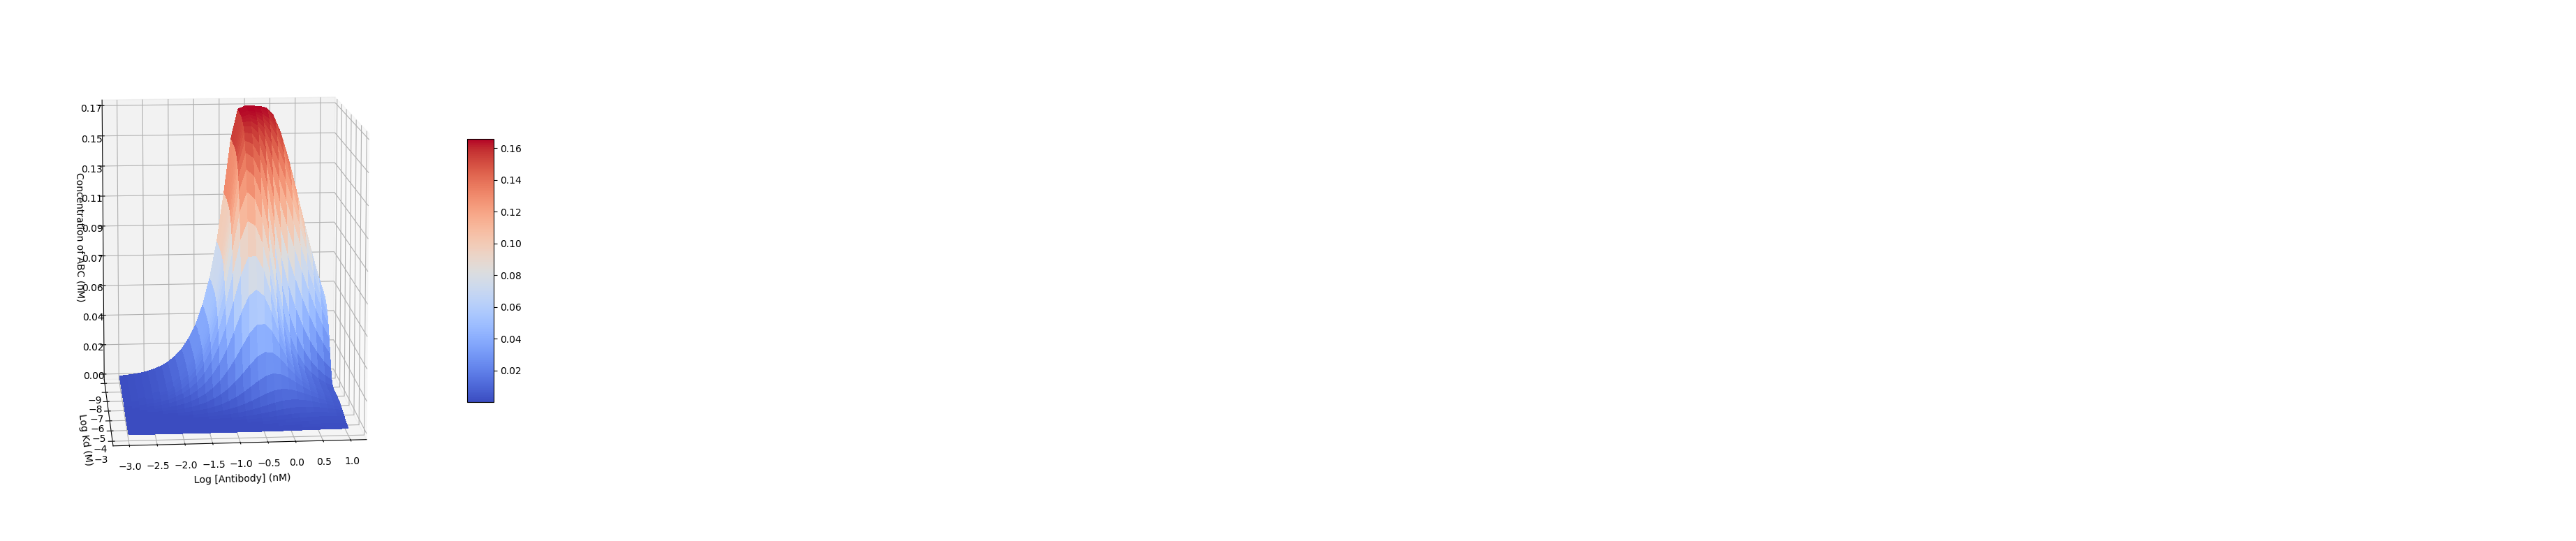

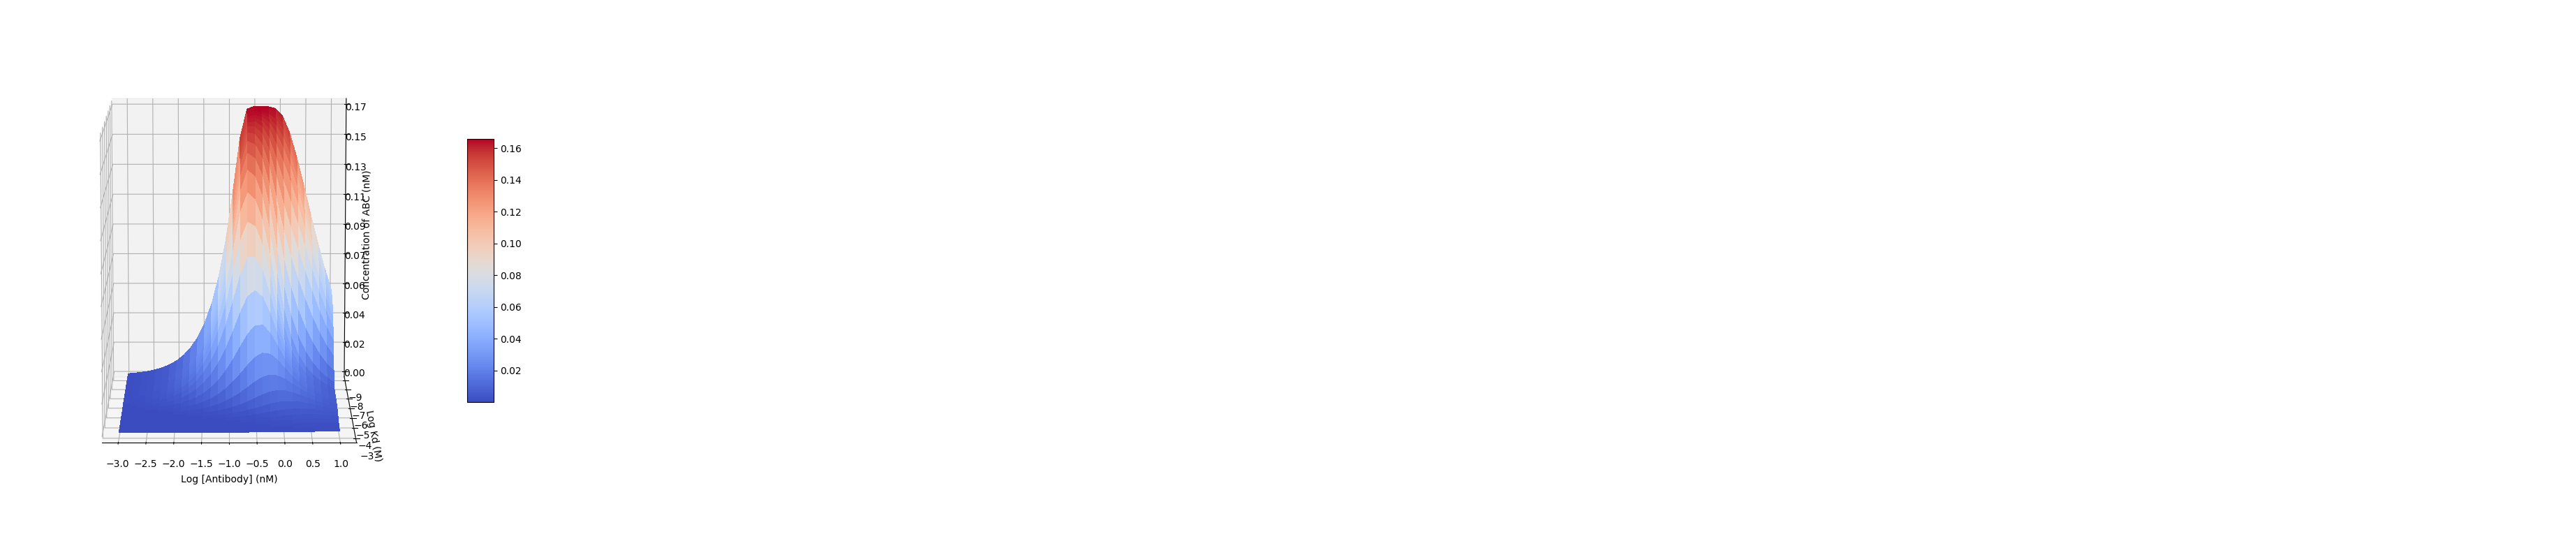

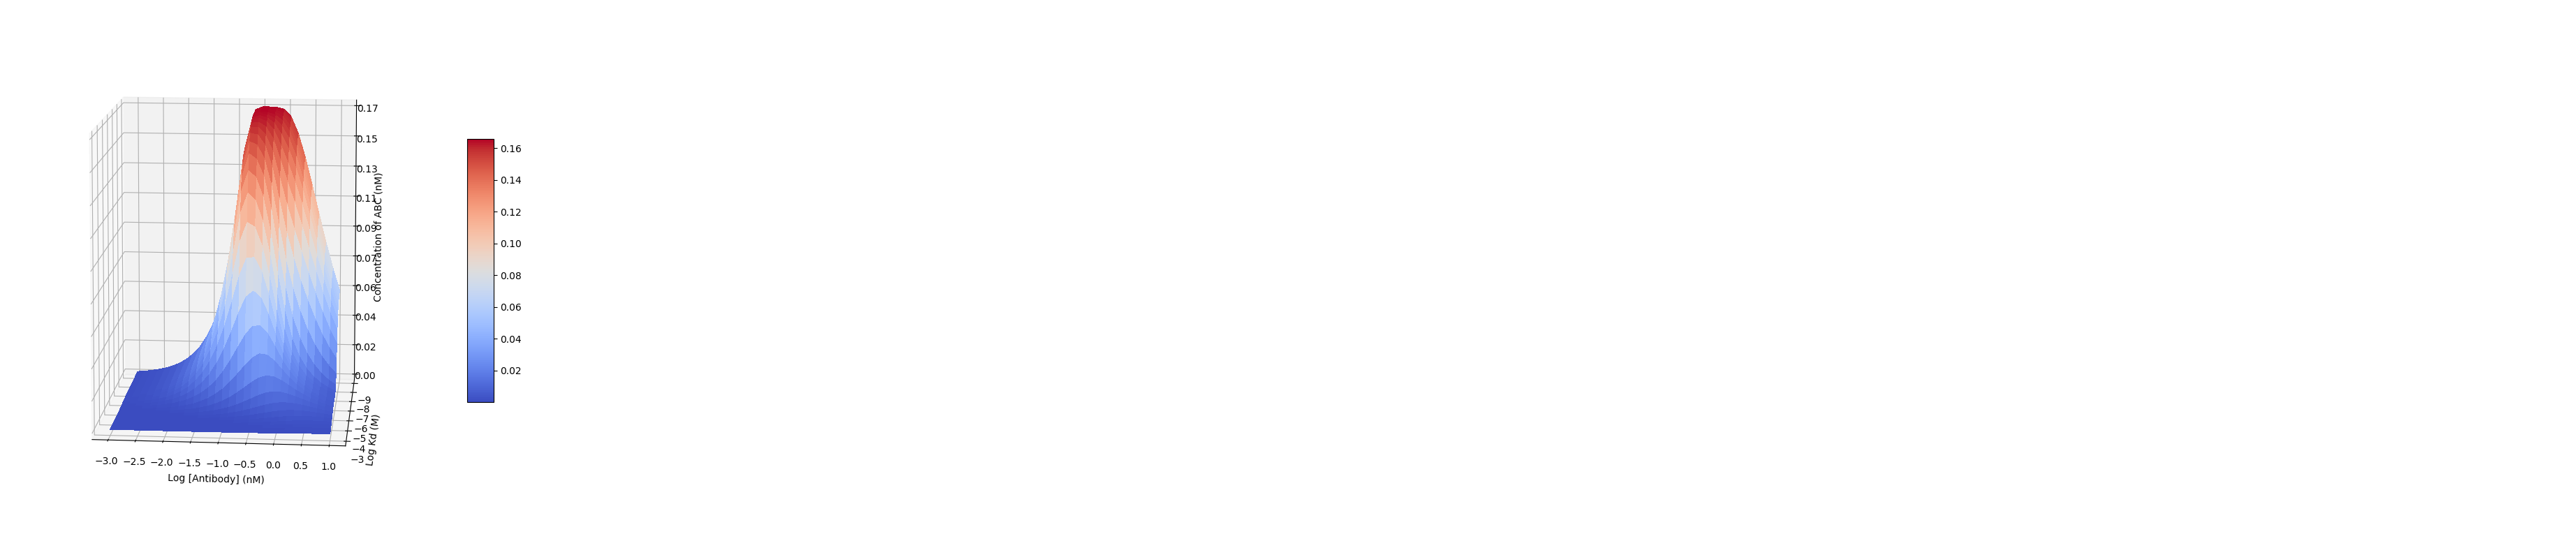

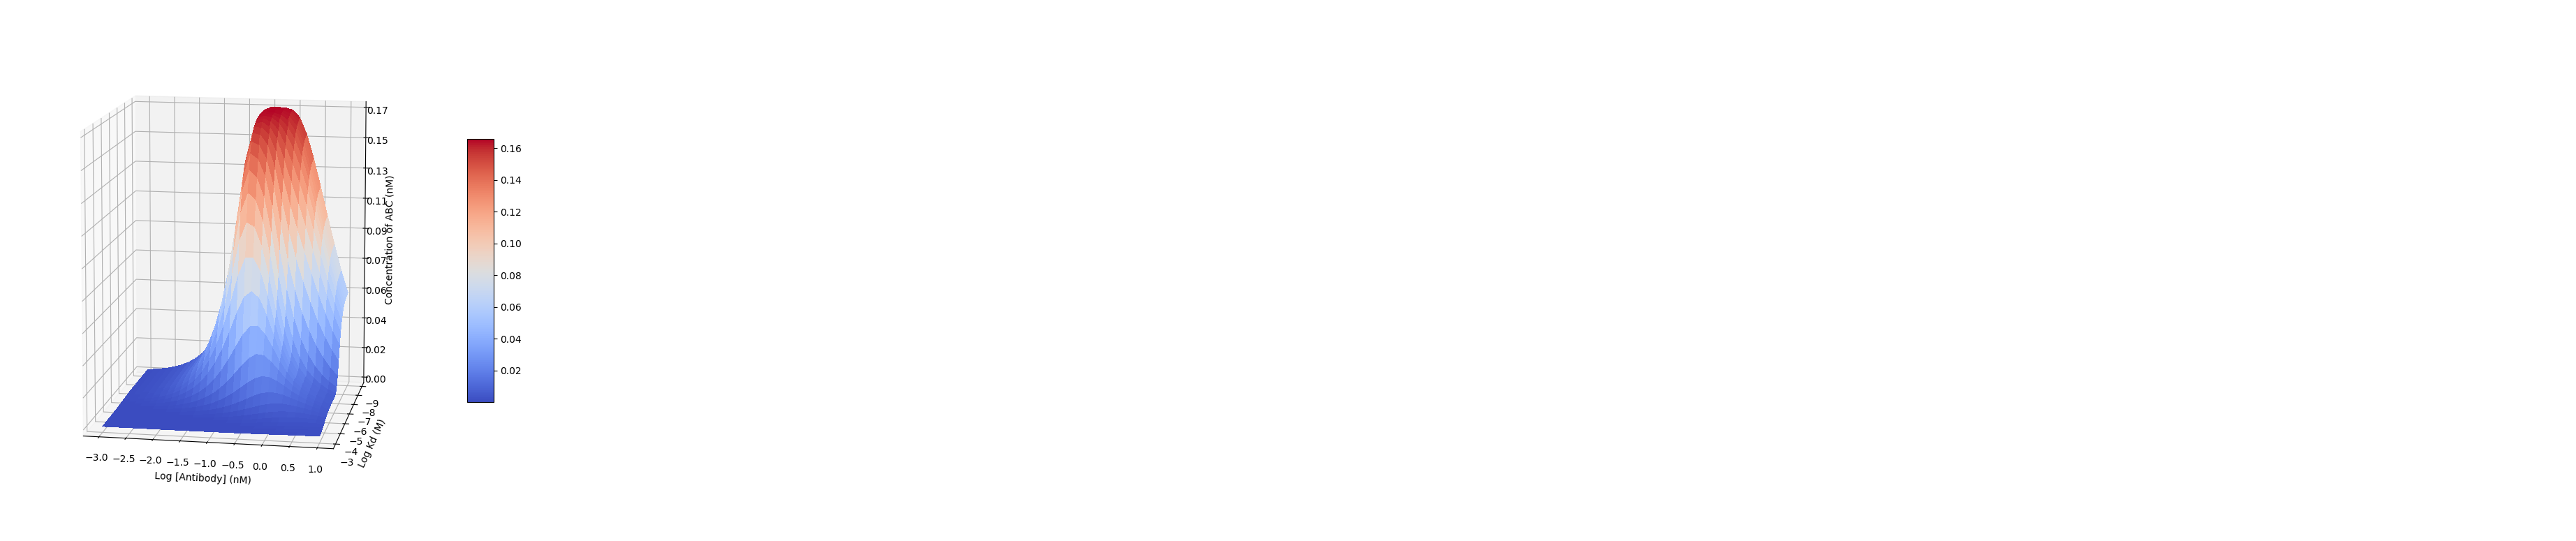

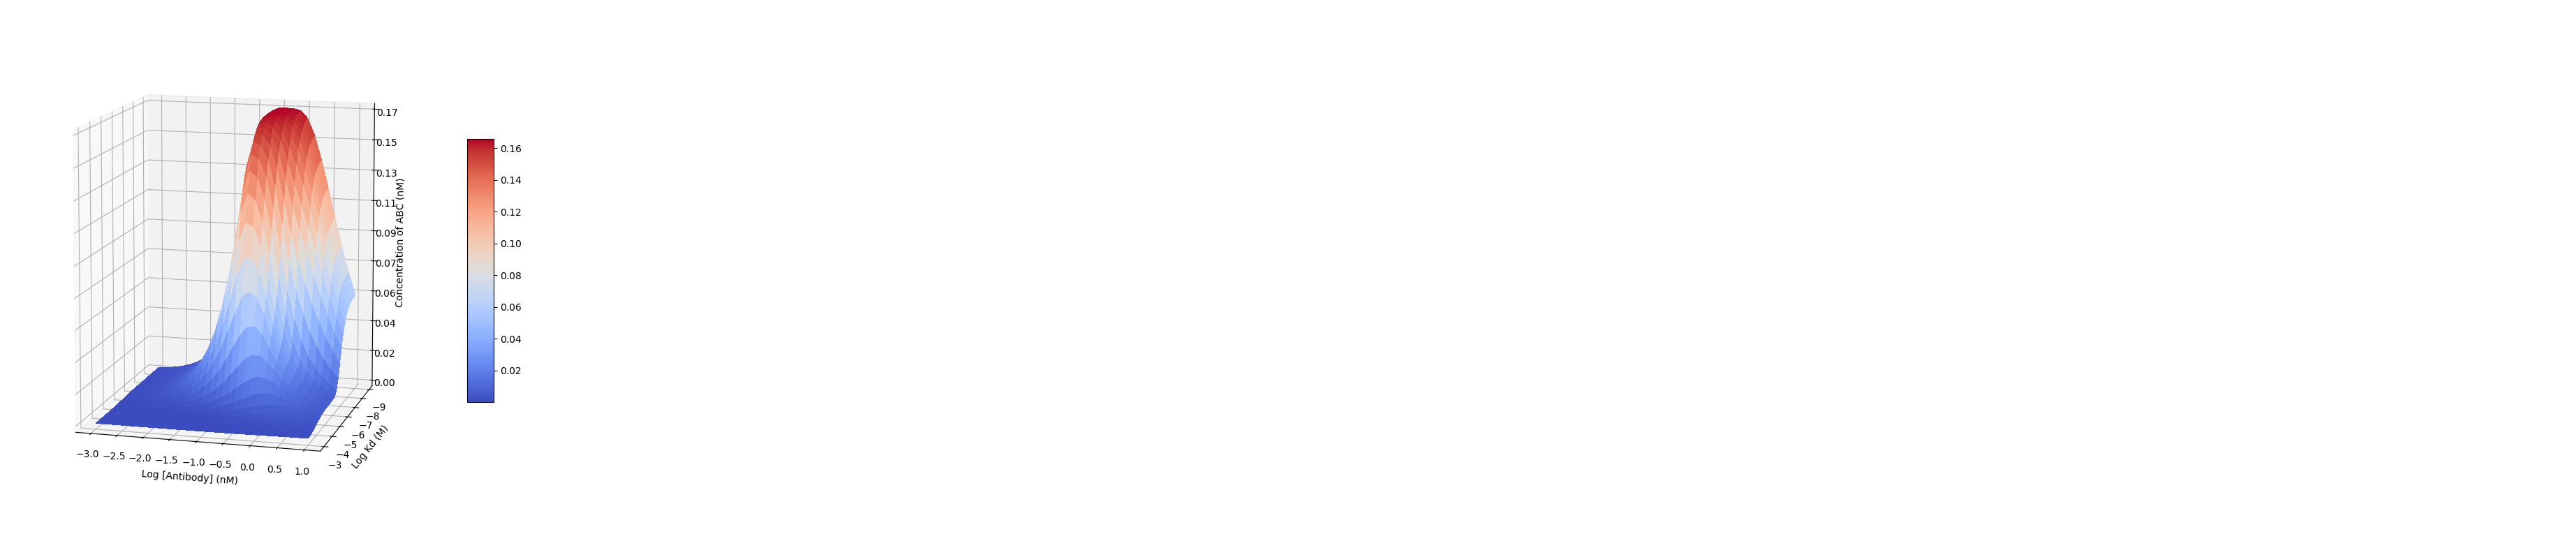

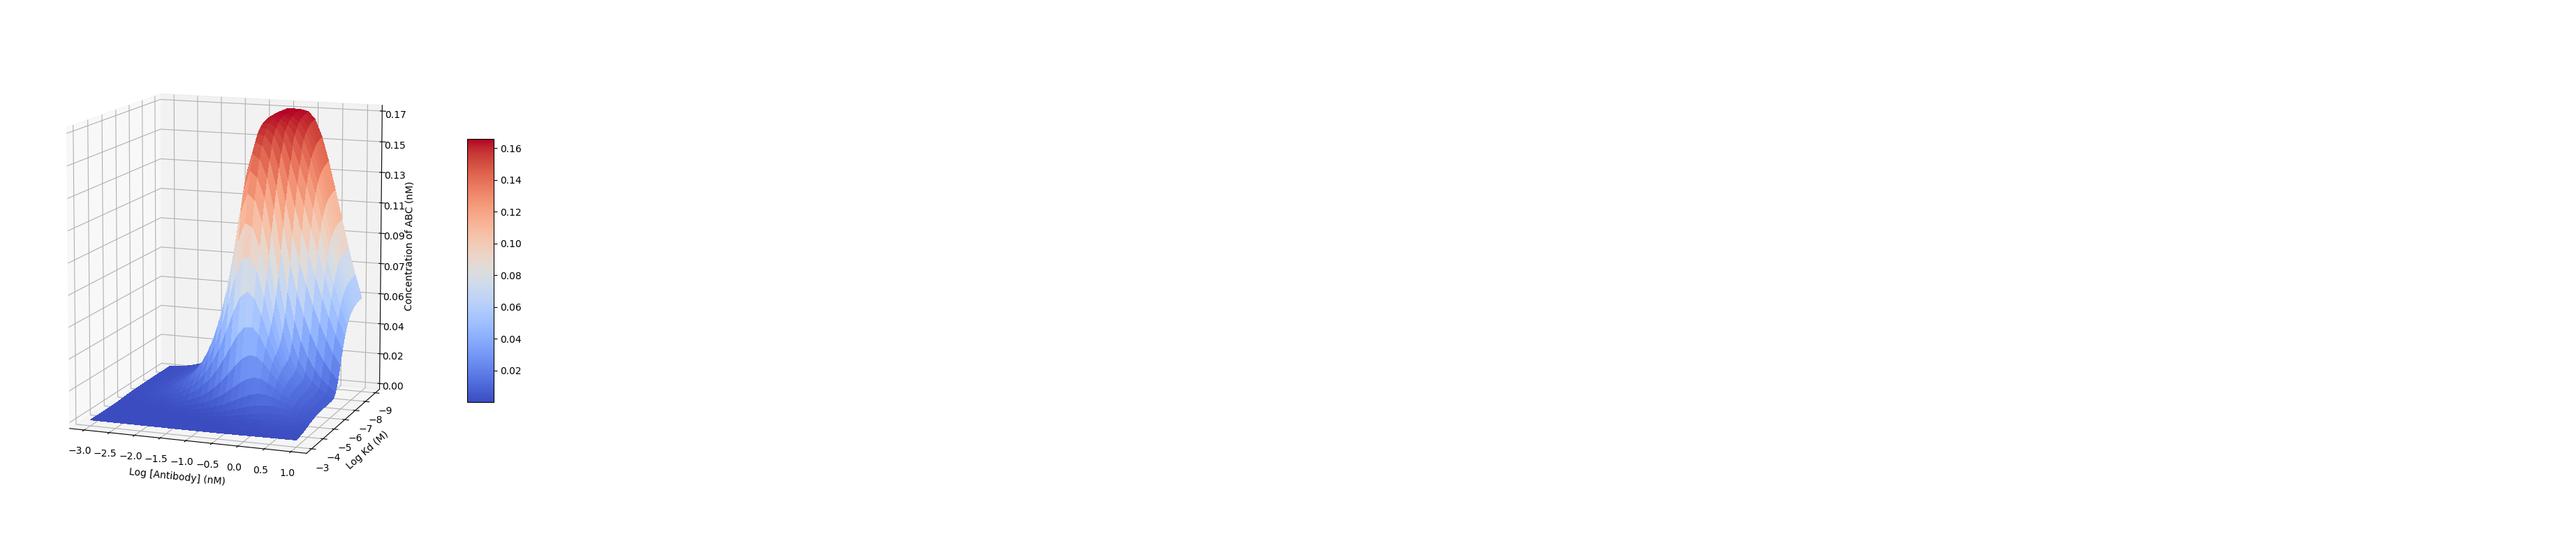

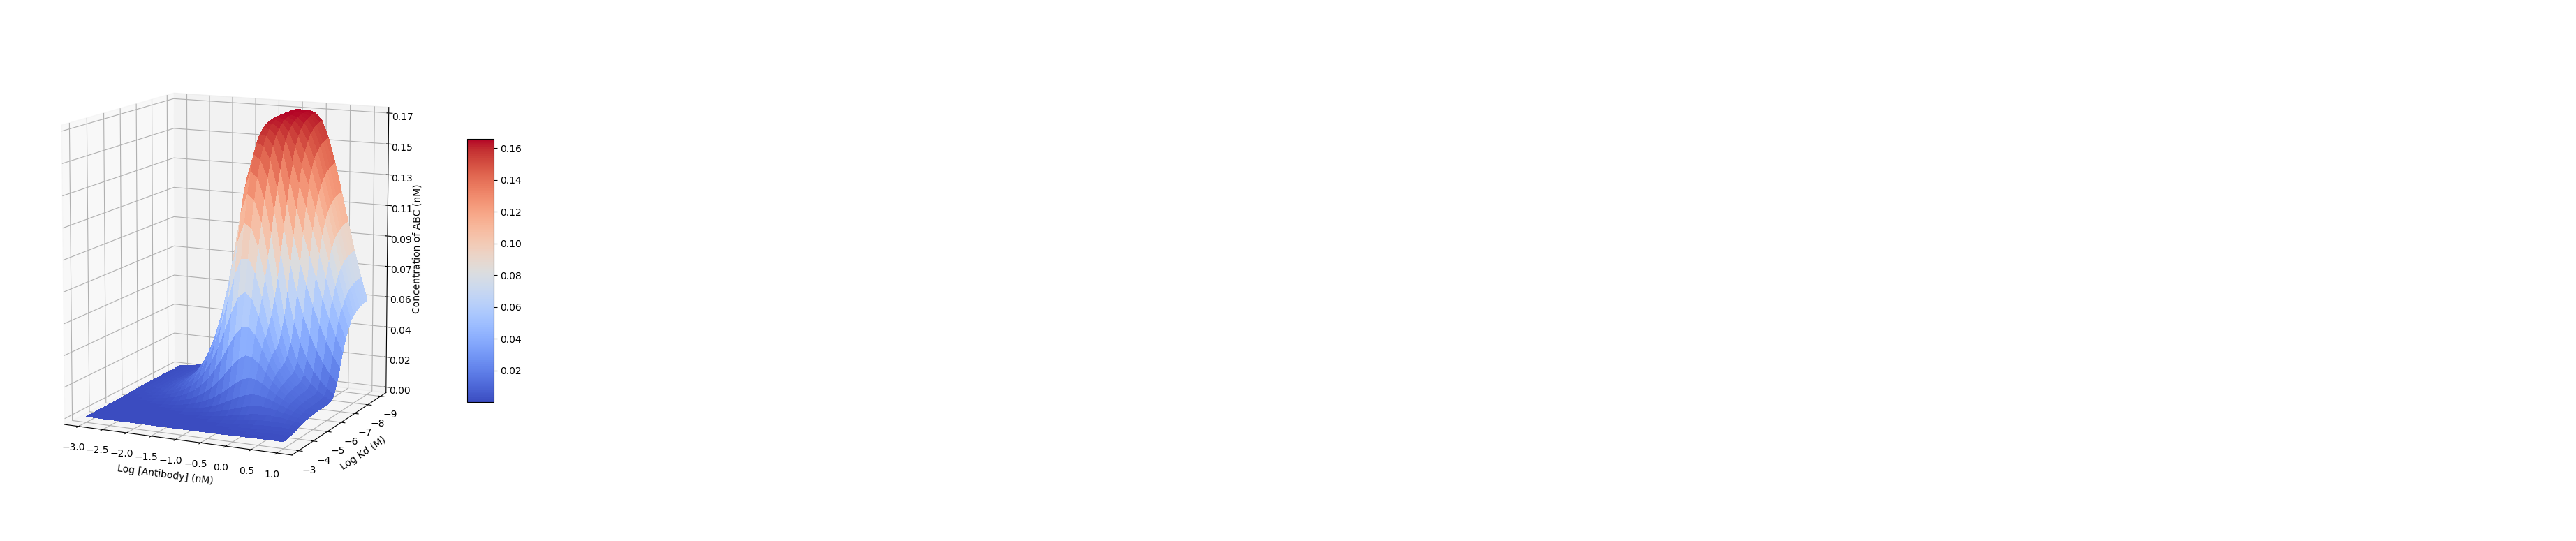

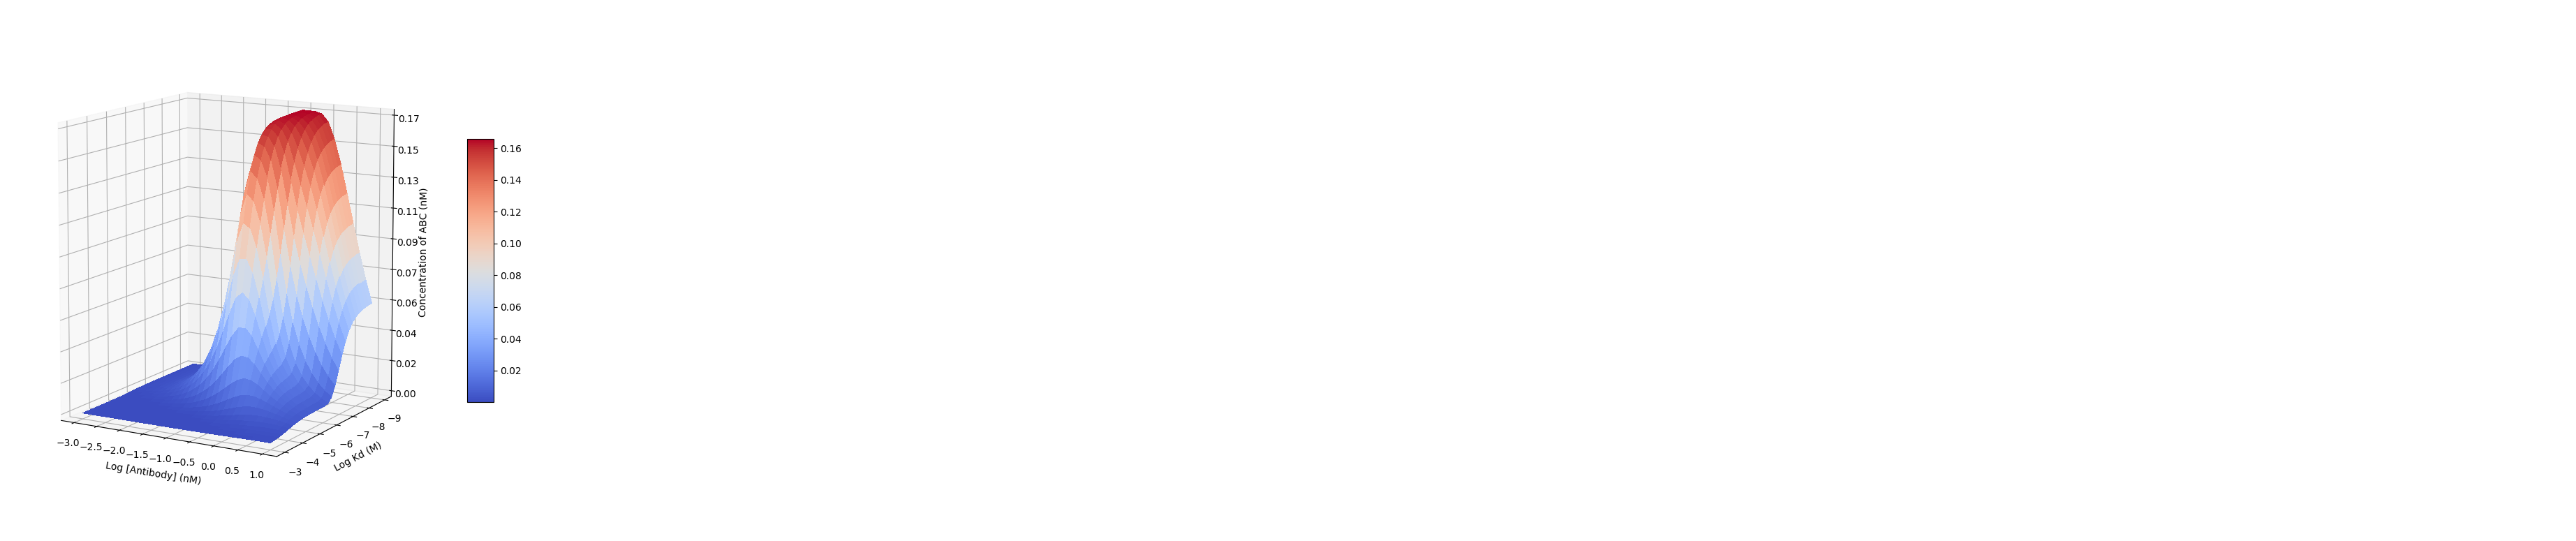

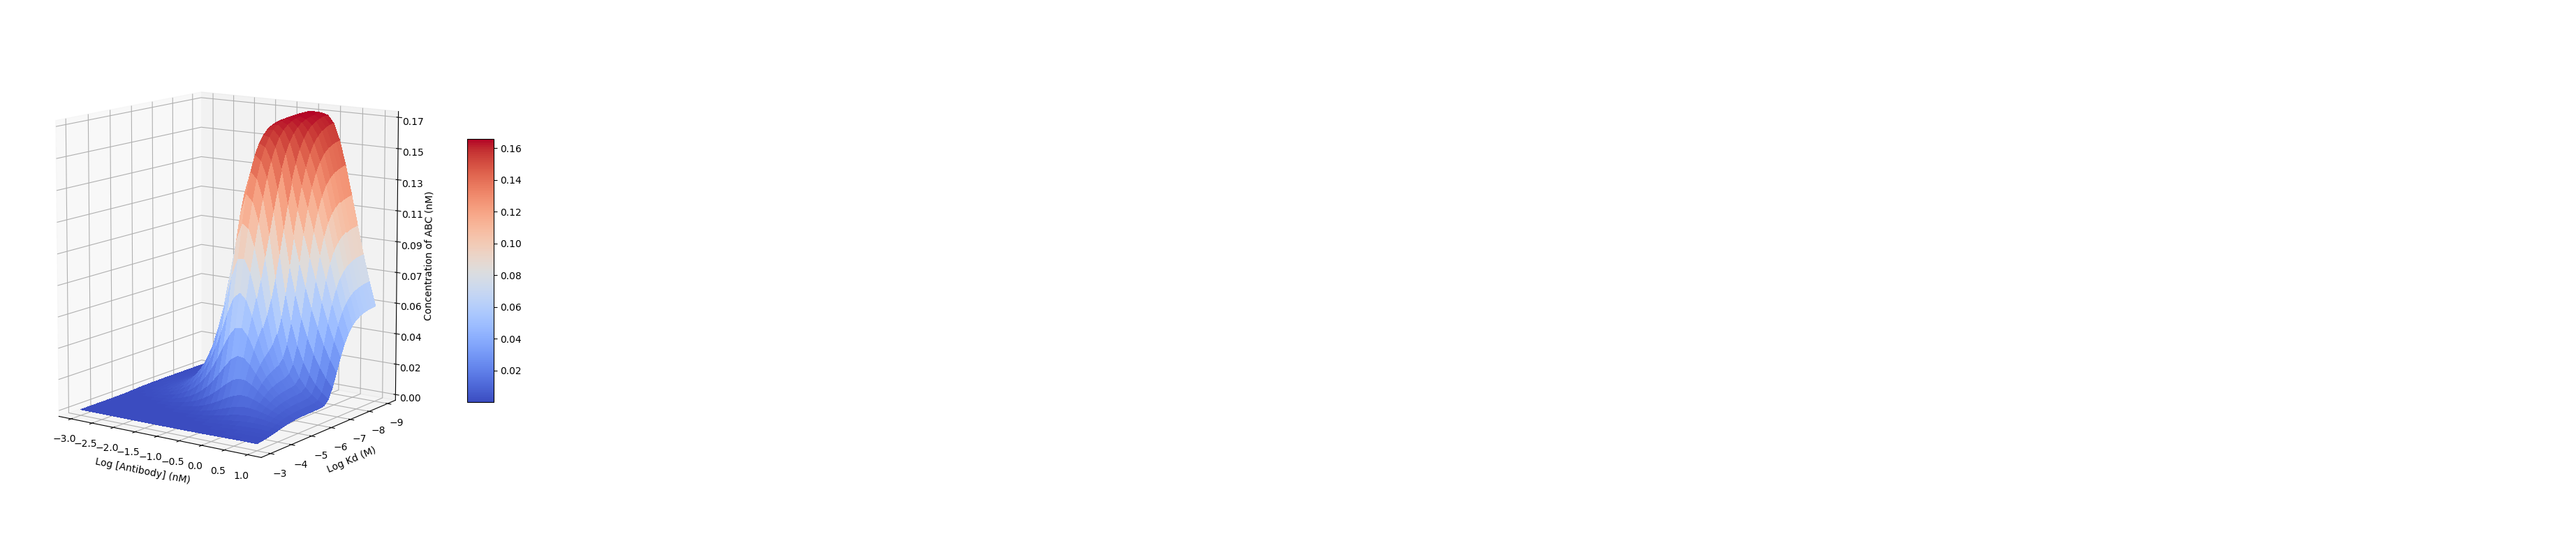

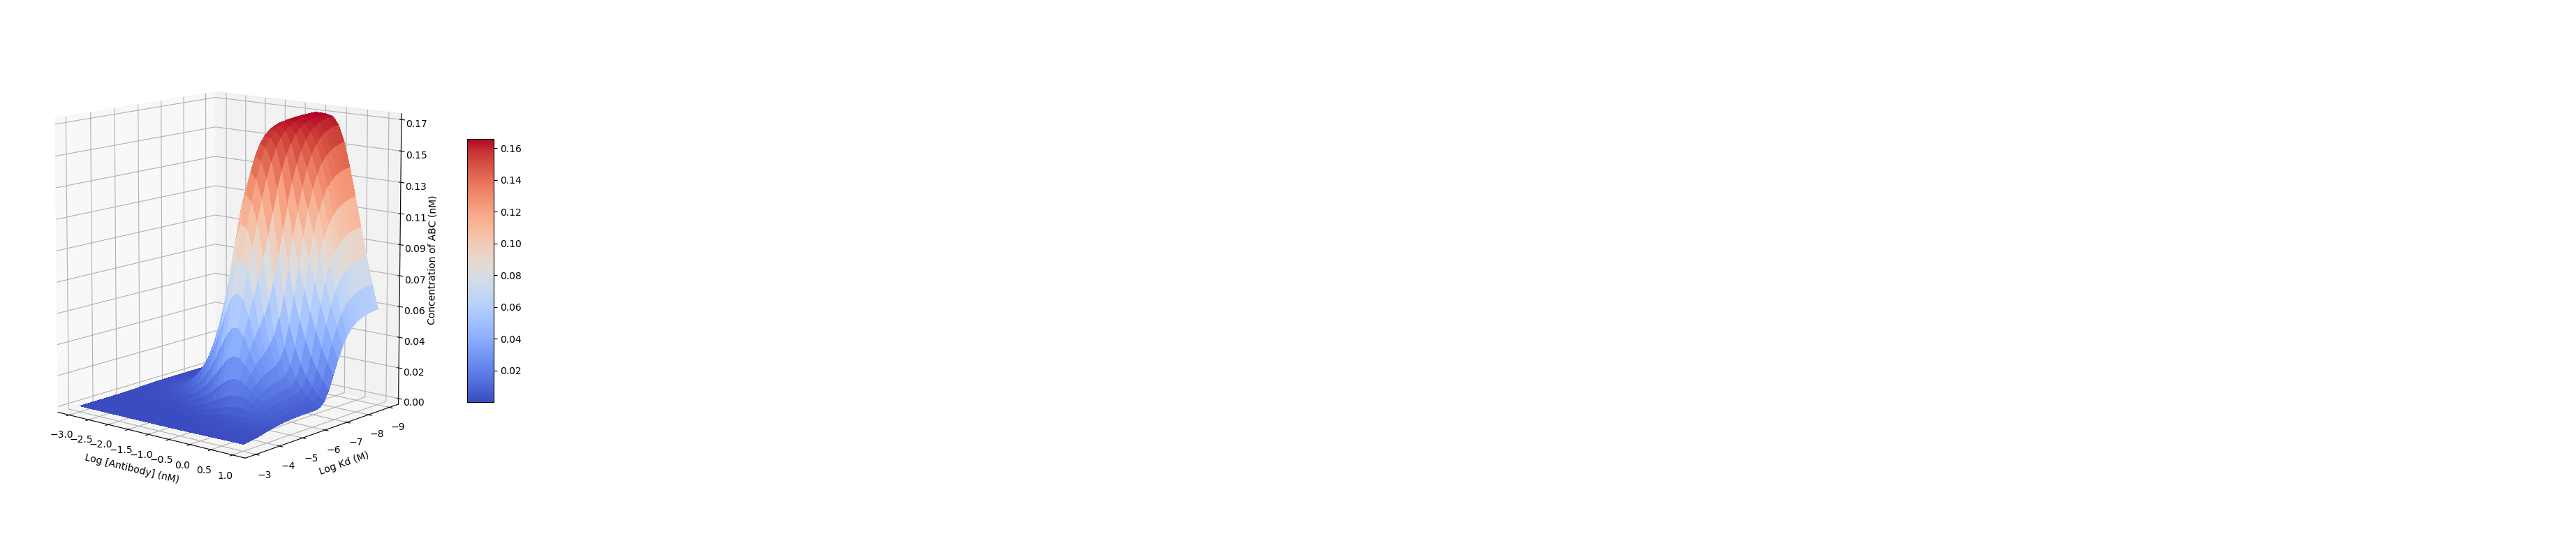

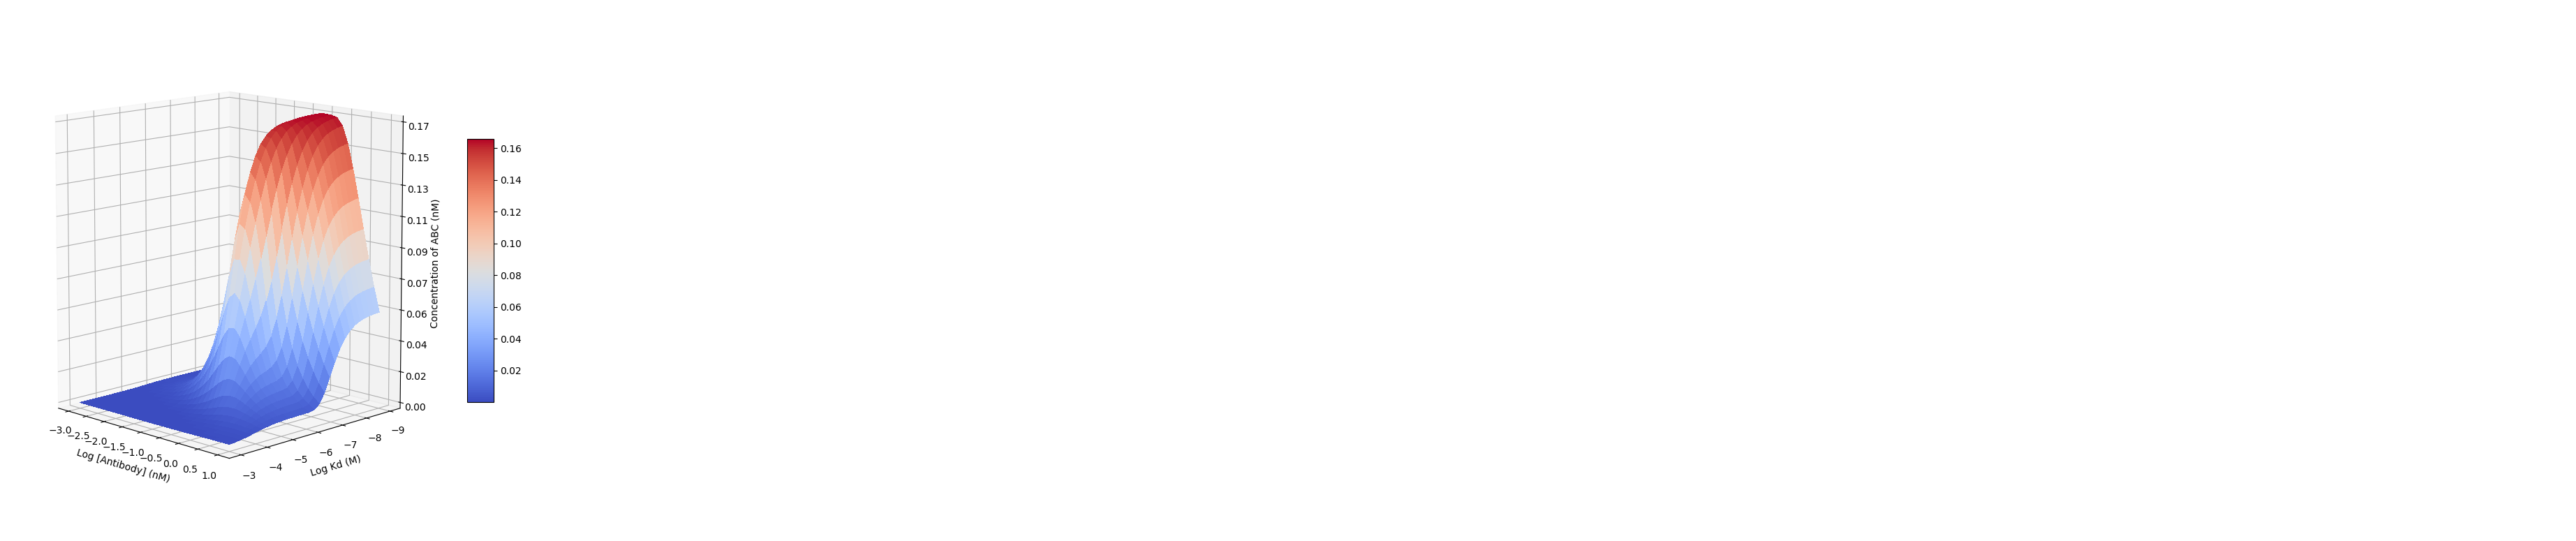

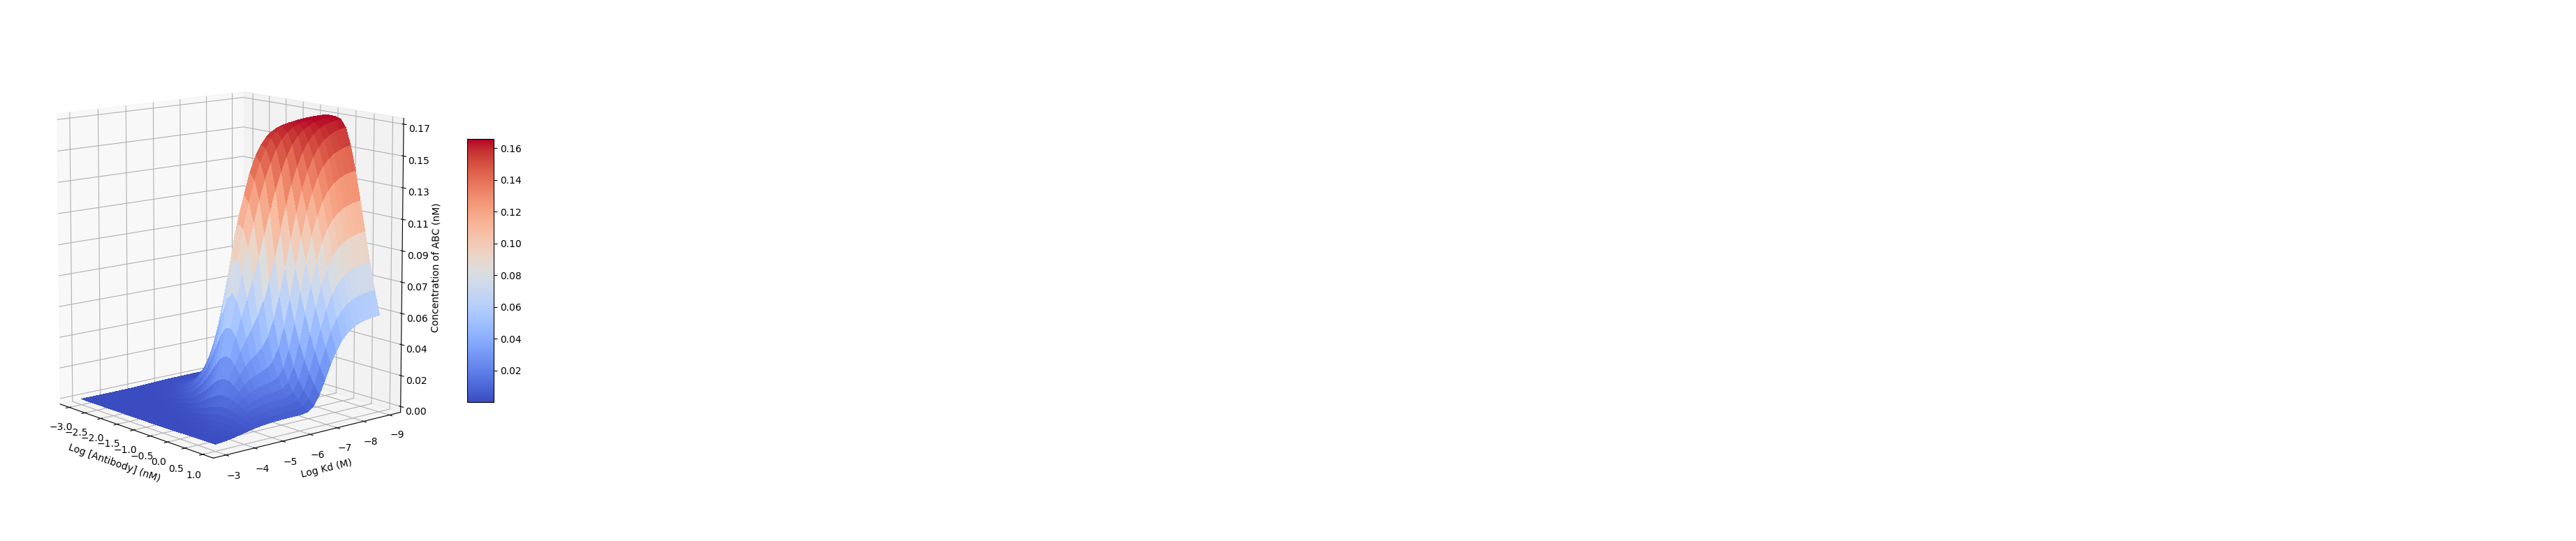

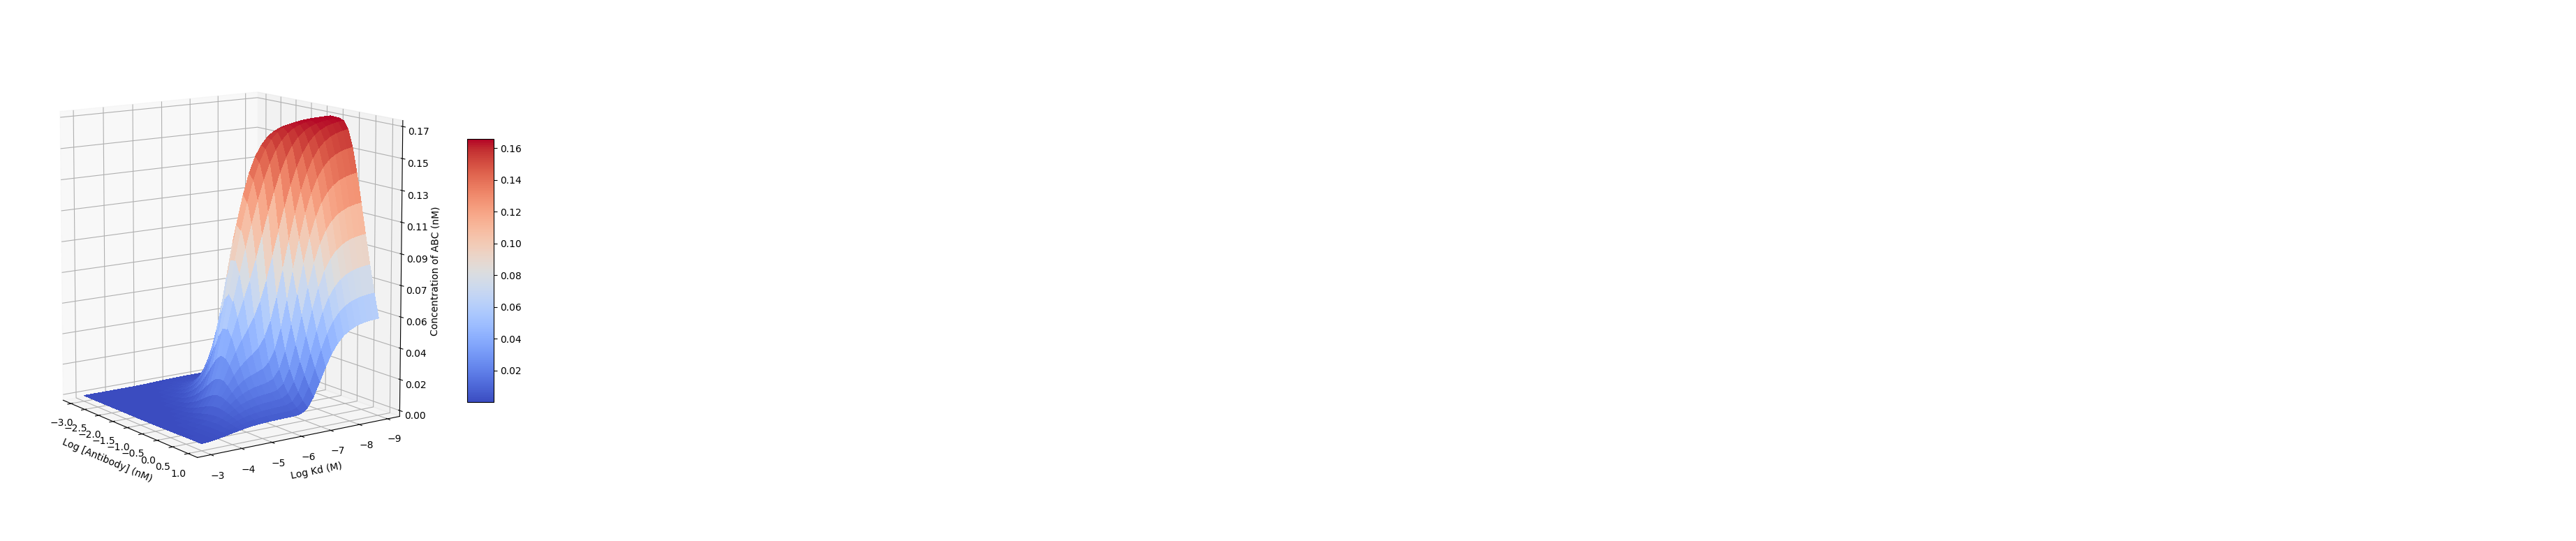

In [ ]:
step_size = 5
for i in range(0,361,step_size):
#     print(i)

    #Create the figure and set the layout
    fig = plt.figure(figsize=(10, 10), dpi=100)
    ax = fig.gca(projection='3d')
    plt.xlabel('Log [Antibody] (nM)')
    plt.ylabel('Log Kd (M)')
    ax.set_zlabel('Concentration of ABC (nM)')

    # Plot the surface.
    surf = ax.plot_surface(lin_X, lin_Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Changing the color scheme
    # surf = ax.plot_surface(lin_X, lin_Y, Z, cmap=plt.cm.viridis,
    #                        linewidth=0, antialiased=False)

    # Customize and details for the the axises
    # ax.set_xlim(-5.01, 5.01)
    # ax.set_ylim(-5.01, 5.01)
    # ax.set_zlim(-1.01, 1.01)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors
    fig.colorbar(surf, shrink=0.5, aspect=10)

    #Creating the plot, saving it, and showing it
    # ax.set_title('Test Surface');
    ax.view_init(10, i)
    ax.invert_xaxis()
    name = str("Figures/Animations/AntibodyDissociation/ParameterScan_AntibodyDissociation_3Dplot_" + "{0:0=3d}".format(i) + '_.png')
    plt.savefig(name)
    plt.show()

### Creating the figures for a bouncy animation
We must create all the frames for the animation before merging them into a gif. This is to create a 180 degree view animation.

In [ ]:
step_size = 5
for i in range(0,181,step_size):
#     print(i)

    #Create the figure and set the layout
    fig = plt.figure(figsize=(10, 10), dpi=100)
    ax = fig.gca(projection='3d')
    plt.xlabel('Log [Antibody] (nM)')
    plt.ylabel('Log Kd (M)')
    ax.set_zlabel('Concentration of ABC (nM)')

    # Plot the surface.
    surf = ax.plot_surface(lin_X, lin_Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Changing the color scheme
    # surf = ax.plot_surface(lin_X, lin_Y, Z, cmap=plt.cm.viridis,
    #                        linewidth=0, antialiased=False)

    # Customize and details for the the axises
    # ax.set_xlim(-5.01, 5.01)
    # ax.set_ylim(-5.01, 5.01)
    # ax.set_zlim(-1.01, 1.01)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors
    fig.colorbar(surf, shrink=0.5, aspect=10)

    #Creating the plot, saving it, and showing it
    # ax.set_title('Test Surface');
    ax.view_init(10, i)
    ax.invert_xaxis()
    i_2 = 360 - i
    name = str("Figures/Animations/AntibodyDissociation/Bouncy/ParameterScan_AntibodyDissociation_3Dplot_" + "{0:0=3d}".format(i) + '_.png')
    name_2 = str("Figures/Animations/AntibodyDissociation/Bouncy/ParameterScan_AntibodyDissociation_3Dplot_" + "{0:0=3d}".format(i_2) + '_.png')
    plt.savefig(name)
    plt.savefig(name_2)
    plt.show()

### This is the most you can do in python
To make these separate '.png' files into a animation ('.gif') you have to go into terminal and run the following code. This uses the ImageMagick package which you have to install on your own. 

#### Bash Code
convert -delay 50 ParameterScan*.png animated_antibodyDissociation.gif